In [130]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [131]:
import warnings
warnings.filterwarnings('ignore')

## Import data and preprocess

Create separate dataframes for each year of output since 2017. The final model can then learn off of 5 years of data before making its predictions for 2022. 
#### Let's get this shit

In [132]:
qb_df = pd.read_csv('qb_fantasy.csv')
qb_df

,Full Name,Position,Team,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),...,Games (2020),Games (2021),Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
0,A.J. McCarron,QB,-,5.24,31.7,21,-,8.2,-,1.3,...,2,-,-,0,-,0,0,1,0,-
1,Aaron Rodgers,QB,Green Bay Packers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,...,16,16,2,1,4,0,2,1,3,3
2,Alex Smith,QB,-,1.01,38.1,19.3,15.1,17.1,15.2,20,...,8,-,1,2,5,1,1,-,0,-
3,Alex Tanney,QB,-,Undrafted,34.6,-,-,8,-,-,...,-,-,-,0,-,-,-,0,-,-
4,Andrew Luck,QB,-,1.01,32.7,20,23,20.1,21.1,-,...,-,-,3,0,2,-,0,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Tyler Huntley,QB,Baltimore Ravens,Undrafted,24.3,21.6,-,-,-,-,...,2,7,-,-,-,-,-,-,0,2
171,Tyrod Taylor,QB,New York Giants,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,...,2,6,0,4,6,4,1,0,0,3
172,Will Grier,QB,Dallas Cowboys,3.36,27.2,22.4,-,-,-,-,...,-,-,-,-,-,-,-,0,-,-
173,Zach Mettenberger,QB,-,6.02,30.9,22.1,11.1,7,-,-,...,-,-,0,1,-,-,-,-,-,-


In [133]:
qb_df_w_team = qb_df.copy()

In [134]:
qb_clean = qb_df.replace({'-':np.nan,'15 gms':15,'9 gms':9,'1 gms':1,'7 gms':7,'2 gms':2,'3 gms':3,'13 gms':13,
                         '5 gms':5,'4.7 vol':4.7,'6.8 vol':6.8,'0.0 vol':0.0,'10.4 vol':10.4,'1.0 vol':1.0,
                          '12.4 vol':12.4,'1.6 vol':1.6,'8.9 vol':8.9,'3.7 vol':3.7,'5.8 vol':5.8,
                         '1.1 vol':1.1,'6.6 vol':6.6,'Undrafted':np.nan
                         }).set_index('Full Name').drop(columns=['Position'])
qb_final_df = qb_clean.drop(columns=['Team']).apply(lambda x: pd.to_numeric(x))
qb_final_df

,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Games (2020),Games (2021),Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
Full Name,,,,,,,,,,,,,,,,,,,,,
A.J. McCarron,5.24,31.7,21.0,NaN,8.2,NaN,1.3,0.1,8.9,0.4000,...,2.0,NaN,NaN,0.0,NaN,0.0,0.0,1.0,0.0,NaN
Aaron Rodgers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,16.0,16.0,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0
Alex Smith,1.01,38.1,19.3,15.1,17.1,15.2,20.0,14.3,NaN,9.9475,...,8.0,NaN,1.0,2.0,5.0,1.0,1.0,NaN,0.0,NaN
Alex Tanney,NaN,34.6,NaN,NaN,8.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
Andrew Luck,1.01,32.7,20.0,23.0,20.1,21.1,NaN,21.1,NaN,NaN,...,NaN,NaN,3.0,0.0,2.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tyler Huntley,NaN,24.3,21.6,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,2.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
Tyrod Taylor,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,2.0,6.0,0.0,4.0,6.0,4.0,1.0,0.0,0.0,3.0
Will Grier,3.36,27.2,22.4,NaN,NaN,NaN,NaN,NaN,2.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [135]:
qb_final_df['fpts_2014'] = qb_final_df['Fantasy Points Per Game (2014)'] * qb_final_df['Games (2014)']
qb_final_df['fpts_2015'] = qb_final_df['Fantasy Points Per Game (2015)'] * qb_final_df['Games (2015)']
qb_final_df['fpts_2016'] = qb_final_df['Fantasy Points Per Game (2016)'] * qb_final_df['Games (2016)']
qb_final_df['fpts_2017'] = qb_final_df['Fantasy Points Per Game (2017)'] * qb_final_df['Games (2017)']
qb_final_df['fpts_2018'] = qb_final_df['Fantasy Points Per Game (2018)'] * qb_final_df['Games (2018)']
qb_final_df['fpts_2019'] = qb_final_df['Fantasy Points Per Game (2019)'] * qb_final_df['Games (2019)']
qb_final_df['fpts_2020'] = qb_final_df['Fantasy Points Per Game (2020)'] * qb_final_df['Games (2020)']
qb_final_df['fpts_2021'] = qb_final_df['Fantasy Points Per Game (2021)'] * qb_final_df['Games (2021)']
qb_final_df = qb_final_df.reset_index()

In [136]:
qb_final_df.columns

Index(['Full Name', 'Draft Pick', 'Age', 'Breakout Age',
       'Fantasy Points Per Game (2014)', 'Fantasy Points Per Game (2015)',
       'Fantasy Points Per Game (2016)', 'Fantasy Points Per Game (2017)',
       'Fantasy Points Per Game (2018)', 'Fantasy Points Per Game (2019)',
       'Fantasy Points Per Game (2020)', 'Fantasy Points Per Game (2021)',
       'Games (2014)', 'Games (2015)', 'Games (2016)', 'Games (2017)',
       'Games (2018)', 'Games (2019)', 'Games (2020)', 'Games (2021)',
       'Rushing Touchdowns (2014)', 'Rushing Touchdowns (2015)',
       'Rushing Touchdowns (2016)', 'Rushing Touchdowns (2017)',
       'Rushing Touchdowns (2018)', 'Rushing Touchdowns (2019)',
       'Rushing Touchdowns (2020)', 'Rushing Touchdowns (2021)', 'fpts_2014',
       'fpts_2015', 'fpts_2016', 'fpts_2017', 'fpts_2018', 'fpts_2019',
       'fpts_2020', 'fpts_2021'],
      dtype='object')

In [8]:
qb_final_df['Team'] = qb_df_w_team['Team']
qb_final_df

,Full Name,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,Rushing Touchdowns (2021),fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Team
0,A.J. McCarron,5.24,31.7,21.0,NaN,8.2,NaN,1.3,0.1,8.9,...,NaN,NaN,57.4,NaN,2.6,0.2,17.8,0.8000,NaN,-
1,Aaron Rodgers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,19.3,17.3,...,3.0,356.8,300.8,382.4,135.8,308.8,276.8,388.2592,337.3008,Green Bay Packers
2,Alex Smith,1.01,38.1,19.3,15.1,17.1,15.2,20.0,14.3,NaN,...,NaN,226.5,273.6,228.0,300.0,143.0,NaN,79.5800,NaN,-
3,Alex Tanney,NaN,34.6,NaN,NaN,8.0,NaN,NaN,NaN,0.0,...,NaN,NaN,8.0,NaN,NaN,NaN,0.0,NaN,NaN,-
4,Andrew Luck,1.01,32.7,20.0,23.0,20.1,21.1,NaN,21.1,NaN,...,NaN,368.0,140.7,316.5,NaN,337.6,NaN,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Tyler Huntley,NaN,24.3,21.6,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.9000,86.6397,Baltimore Ravens
171,Tyrod Taylor,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,10.9,1.5,...,3.0,-0.3,274.4,273.0,226.5,43.6,6.0,9.0200,86.7402,New York Giants
172,Will Grier,3.36,27.2,22.4,NaN,NaN,NaN,NaN,NaN,2.7,...,NaN,NaN,NaN,NaN,NaN,NaN,5.4,NaN,NaN,Dallas Cowboys
173,Zach Mettenberger,6.02,30.9,22.1,11.1,7.0,NaN,NaN,NaN,NaN,...,NaN,77.7,49.0,NaN,NaN,NaN,NaN,NaN,NaN,-


In [38]:
final_data = pd.DataFrame()
final_data_id = pd.DataFrame()

### 2017 predictions

In [39]:
qb_2017 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
    'Games (2014)', 'Games (2015)','Games (2016)', 
    'fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','Draft Pick','Breakout Age','Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)'
                      ]].dropna(subset=['Fantasy Points Per Game (2017)'])
qb_2017

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),Games (2016),fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,NaN,7.0,NaN,NaN,57.4,NaN,2.6,5.24,21.0,NaN,0.0,NaN
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,16.0,16.0,16.0,356.8,300.8,382.4,135.8,1.24,19.8,2.0,1.0,4.0
2,Alex Smith,38.1,-,15.1,17.1,15.2,20.0,15.0,16.0,15.0,226.5,273.6,228.0,300.0,1.01,19.3,1.0,2.0,5.0
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.0,13.0,16.0,240.0,250.9,268.8,222.4,2.03,20.9,4.0,3.0,4.0
6,Austin Davis,33.0,-,13.0,7.4,NaN,-0.1,9.0,3.0,NaN,117.0,22.2,NaN,-0.1,NaN,21.3,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Tom Brady,44.8,Tampa Bay Buccaneers,17.9,22.0,21.5,18.7,16.0,16.0,12.0,286.4,352.0,258.0,299.2,6.33,21.1,0.0,3.0,0.0
161,Tom Savage,32.1,-,0.7,NaN,5.9,7.1,2.0,NaN,3.0,1.4,NaN,17.7,56.8,4.35,23.4,0.0,NaN,0.0
166,Trevor Siemian,30.4,Chicago Bears,NaN,-0.1,14.0,12.7,NaN,1.0,14.0,NaN,-0.1,196.0,139.7,NaN,21.7,NaN,0.0,0.0
169,Tyler Bray,30.4,-,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,18.7,NaN,NaN,NaN


In [40]:
qb_2017.to_csv('qb_2017.csv')

In [41]:
qb_2017_team = pd.read_csv('qb_2017_team.csv').drop(columns=['Unnamed: 0'])
qb_2017_team

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),Games (2016),fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016)
0,A.J. McCarron,31.7,Cincinnati Bengals,0,NaN,8.2,NaN,1.3,NaN,7.0,NaN,NaN,57.4,NaN,2.6,5.24,21.0,NaN,0.0,NaN
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,16.0,16.0,16.0,356.8,300.8,382.4,135.8,1.24,19.8,2.0,1.0,4.0
2,Alex Smith,38.1,Kansas City Chiefs,1,15.1,17.1,15.2,20.0,15.0,16.0,15.0,226.5,273.6,228.0,300.0,1.01,19.3,1.0,2.0,5.0
3,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.0,13.0,16.0,240.0,250.9,268.8,222.4,2.03,20.9,4.0,3.0,4.0
4,Austin Davis,33.0,Seattle Seahawks,0,13.0,7.4,NaN,-0.1,9.0,3.0,NaN,117.0,22.2,NaN,-0.1,NaN,21.3,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Tom Brady,44.8,New England Patriots,1,17.9,22.0,21.5,18.7,16.0,16.0,12.0,286.4,352.0,258.0,299.2,6.33,21.1,0.0,3.0,0.0
69,Tom Savage,32.1,Houston Texans,0,0.7,NaN,5.9,7.1,2.0,NaN,3.0,1.4,NaN,17.7,56.8,4.35,23.4,0.0,NaN,0.0
70,Trevor Siemian,30.4,Denver Broncos,1,NaN,-0.1,14.0,12.7,NaN,1.0,14.0,NaN,-0.1,196.0,139.7,NaN,21.7,NaN,0.0,0.0
71,Tyler Bray,30.4,Kansas City Chiefs,0,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,18.7,NaN,NaN,NaN


In [42]:
team_2017 = pd.read_csv('brady_input_2017.csv')
team_2017

,Team,1
0,-,3.250383
1,Arizona Cardinals,1.326759
2,Atlanta Falcons,1.935694
3,Baltimore Ravens,0.602106
4,Buffalo Bills,0.968663
5,Carolina Panthers,1.155661
6,Chicago Bears,0.759393
7,Cincinnati Bengals,1.122148
8,Cleveland Browns,0.870288
9,Dallas Cowboys,1.933728


In [43]:
qb_2017_final = qb_2017_team.merge(team_2017, on='Team',how='inner')
qb_2017_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),...,fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),1
0,A.J. McCarron,31.7,Cincinnati Bengals,0,NaN,8.2,NaN,1.3,NaN,7.0,...,NaN,57.4,NaN,2.6,5.24,21.0,NaN,0.0,NaN,1.122148
1,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.0,13.0,...,240.0,250.9,268.8,222.4,2.03,20.9,4.0,3.0,4.0,1.122148
2,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,16.0,16.0,...,356.8,300.8,382.4,135.8,1.24,19.8,2.0,1.0,4.0,1.407871
3,Brett Hundley,29.0,Green Bay Packers,0,NaN,NaN,-0.1,12.1,NaN,NaN,...,NaN,NaN,-0.4,133.1,5.11,19.2,NaN,NaN,0.0,1.407871
4,Joe Callahan,29.0,Green Bay Packers,0,NaN,NaN,NaN,0.4,NaN,NaN,...,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN,1.407871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Marcus Mariota,28.6,Tennessee Titans,1,NaN,17.8,17.9,15.0,NaN,12.0,...,NaN,213.6,268.5,225.0,1.02,18.9,NaN,2.0,2.0,1.533410
69,Matt Cassel,40.1,Tennessee Titans,0,8.9,9.0,4.4,2.2,3.0,8.0,...,26.7,72.0,17.6,4.4,7.16,NaN,0.0,0.0,0.0,1.533410
70,Matt Ryan,37.1,Atlanta Falcons,1,18.5,15.5,21.9,15.0,16.0,16.0,...,296.0,248.0,350.4,240.0,1.03,20.3,0.0,0.0,0.0,1.935694
71,Mike Glennon,32.5,Chicago Bears,0,15.9,12.8,7.0,9.7,6.0,13.0,...,95.4,166.4,7.0,38.8,3.11,21.7,0.0,0.0,0.0,0.759393


In [44]:
qb_2017_final['y'] = np.where(qb_2017_final['fpts_2017'] > 300,1,0)
qb_2017_final['y'].value_counts()

0    71
1     2
Name: y, dtype: int64

In [45]:
fpts_df_2017 = qb_2017_final[['fpts_2014','fpts_2015', 'fpts_2016']]

In [46]:
konami_df_2017 = qb_2017_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)']]

In [47]:
fppg_df_2017 = qb_2017_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)']]

In [48]:
games_df_2017 = qb_2017_final[['Games (2014)','Games (2015)','Games (2016)']]

In [49]:
df_2017 = qb_2017_final[['y','starter']]
df_2017

,y,starter
0,0,0
1,0,1
2,0,1
3,0,0
4,0,0
...,...,...
68,0,1
69,0,0
70,0,1
71,0,0


In [50]:
df_2017['age'] = qb_2017_final['Age'] - 5
df_2017

,y,starter,age
0,0,0,26.7
1,0,1,29.6
2,0,1,33.5
3,0,0,24.0
4,0,0,24.0
...,...,...,...
68,0,1,23.6
69,0,0,35.1
70,0,1,32.1
71,0,0,27.5


In [51]:
df_2017['max_pts'] = fpts_df_2017.max(axis=1)
df_2017

,y,starter,age,max_pts
0,0,0,26.7,57.4
1,0,1,29.6,268.8
2,0,1,33.5,382.4
3,0,0,24.0,-0.4
4,0,0,24.0,NaN
...,...,...,...,...
68,0,1,23.6,268.5
69,0,0,35.1,72.0
70,0,1,32.1,350.4
71,0,0,27.5,166.4


In [52]:
df_2017['avg_pts'] = fpts_df_2017.mean(axis=1)
df_2017

,y,starter,age,max_pts,avg_pts
0,0,0,26.7,57.4,57.400000
1,0,1,29.6,268.8,253.233333
2,0,1,33.5,382.4,346.666667
3,0,0,24.0,-0.4,-0.400000
4,0,0,24.0,NaN,NaN
...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000
69,0,0,35.1,72.0,38.766667
70,0,1,32.1,350.4,298.133333
71,0,0,27.5,166.4,89.600000


In [53]:
df_2017['last_pts'] = fpts_df_2017['fpts_2016']
df_2017

,y,starter,age,max_pts,avg_pts,last_pts
0,0,0,26.7,57.4,57.400000,NaN
1,0,1,29.6,268.8,253.233333,268.8
2,0,1,33.5,382.4,346.666667,382.4
3,0,0,24.0,-0.4,-0.400000,-0.4
4,0,0,24.0,NaN,NaN,NaN
...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5
69,0,0,35.1,72.0,38.766667,17.6
70,0,1,32.1,350.4,298.133333,350.4
71,0,0,27.5,166.4,89.600000,7.0


In [54]:
df_2017['3_yr_trail_avg_fppg'] = fppg_df_2017.mean(axis=1)
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg
0,0,0,26.7,57.4,57.400000,NaN,8.200000
1,0,1,29.6,268.8,253.233333,268.8,17.033333
2,0,1,33.5,382.4,346.666667,382.4,21.666667
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000
4,0,0,24.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000
69,0,0,35.1,72.0,38.766667,17.6,7.433333
70,0,1,32.1,350.4,298.133333,350.4,18.633333
71,0,0,27.5,166.4,89.600000,7.0,11.900000


In [55]:
df_2017['hit_rate'] = fpts_df_2017[fpts_df_2017 > 300].count(axis = 1) / fpts_df_2017.count(axis=1)
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000


In [56]:
df_2017['Draft Pick'] = qb_2017_final['Draft Pick']
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11


In [57]:
df_2017['supporting_cast'] = qb_2017_final['1']
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871
...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393


In [58]:
df_2017['breakout_age'] = qb_2017_final['Breakout Age']
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN
...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7


In [59]:
df_2017['konami'] = konami_df_2017.mean(axis=1)
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,3.666667
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,2.333333
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9,2.000000
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN,0.000000
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3,0.000000
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7,0.000000


In [60]:
df_2017['games_played_rate'] = games_df_2017.sum(axis=1) / (games_df_2017.count(axis=1)*16)
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,3.666667,0.937500
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,2.333333,1.000000
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9,2.000000,0.843750
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN,0.000000,0.312500
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3,0.000000,1.000000
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7,0.000000,0.416667


In [61]:
df_2017_id = df_2017.copy()
df_2017_id['id'] = qb_2017_final['Full Name']
df_2017_id['year'] = 2017
df_2017_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,3.666667,0.937500,Andy Dalton,2017
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,2.333333,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9,2.000000,0.843750,Marcus Mariota,2017
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN,0.000000,0.312500,Matt Cassel,2017
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3,0.000000,1.000000,Matt Ryan,2017
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7,0.000000,0.416667,Mike Glennon,2017


In [62]:
final_data = final_data.append(df_2017)
final_data

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,3.666667,0.937500
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,2.333333,1.000000
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9,2.000000,0.843750
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN,0.000000,0.312500
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3,0.000000,1.000000
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7,0.000000,0.416667


In [63]:
final_data_id = final_data_id.append(df_2017_id)
final_data_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,3.666667,0.937500,Andy Dalton,2017
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,2.333333,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9,2.000000,0.843750,Marcus Mariota,2017
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN,0.000000,0.312500,Matt Cassel,2017
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3,0.000000,1.000000,Matt Ryan,2017
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7,0.000000,0.416667,Mike Glennon,2017


### 2018

In [64]:
qb_2018 = qb_final_df[['Full Name','Age', 'Team','Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','Draft Pick',
                      'Breakout Age','Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)'
                      ]].dropna(subset=['Fantasy Points Per Game (2018)'])
qb_2018

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Games (2014),Games (2015),...,fpts_2015,fpts_2016,fpts_2017,fpts_2018,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,0.1,NaN,7.0,...,57.4,NaN,2.6,0.2,5.24,21.0,NaN,0.0,NaN,0.0
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,16.0,16.0,...,300.8,382.4,135.8,308.8,1.24,19.8,2.0,1.0,4.0,0.0
2,Alex Smith,38.1,-,15.1,17.1,15.2,20.0,14.3,15.0,16.0,...,273.6,228.0,300.0,143.0,1.01,19.3,1.0,2.0,5.0,1.0
4,Andrew Luck,32.7,-,23.0,20.1,21.1,NaN,21.1,16.0,7.0,...,140.7,316.5,NaN,337.6,1.01,20.0,3.0,0.0,2.0,NaN
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.0,13.0,...,250.9,268.8,222.4,185.9,2.03,20.9,4.0,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,Sean Mannion,30.1,Minnesota Vikings,NaN,1.2,-0.3,1.0,0.0,NaN,1.0,...,1.2,-0.3,5.0,0.0,3.25,20.4,NaN,0.0,0.0,0.0
156,Taylor Heinicke,29.2,Washington Commanders,NaN,NaN,NaN,0.6,3.4,NaN,NaN,...,NaN,NaN,0.6,17.0,NaN,19.5,NaN,NaN,NaN,0.0
157,Teddy Bridgewater,29.6,Miami Dolphins,14.4,13.0,NaN,-1.3,2.1,13.0,16.0,...,208.0,NaN,-1.3,8.4,1.32,18.8,1.0,3.0,NaN,0.0
160,Tom Brady,44.8,Tampa Bay Buccaneers,17.9,22.0,21.5,18.7,18.2,16.0,16.0,...,352.0,258.0,299.2,291.2,6.33,21.1,0.0,3.0,0.0,0.0


In [65]:
qb_2018.to_csv('qb_2018.csv')

In [66]:
qb_2018_team = pd.read_csv('qb_2018_team.csv').drop(columns=['Unnamed: 0'])

team_2018 = pd.read_csv('brady_input_2018.csv')

qb_2018_final = qb_2018_team.merge(team_2018, on='Team',how='inner')
qb_2018_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Games (2014),...,fpts_2016,fpts_2017,fpts_2018,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),1
0,A.J. McCarron,31.7,Buffalo Bills,0,NaN,8.2,NaN,1.3,0.1,NaN,...,NaN,2.6,0.2,5.24,21.0,NaN,0.0,NaN,0.0,0.641736
1,Derek Anderson,39.0,Buffalo Bills,0,10.1,0.4,3.9,0.2,5.2,5.0,...,19.5,0.6,10.4,6.39,19.2,0.0,0.0,0.0,0.0,0.641736
2,Josh Allen,26.0,Buffalo Bills,1,NaN,NaN,NaN,NaN,18.2,NaN,...,NaN,NaN,218.4,1.07,20.3,NaN,NaN,NaN,NaN,0.641736
3,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,16.0,...,382.4,135.8,308.8,1.24,19.8,2.0,1.0,4.0,0.0,1.087887
4,DeShone Kizer,26.4,Green Bay Packers,0,NaN,NaN,NaN,13.2,2.5,NaN,...,NaN,198.0,7.5,2.20,19.7,NaN,NaN,NaN,5.0,1.087887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Matt Cassel,40.1,Detroit Lions,0,8.9,9.0,4.4,2.2,1.3,3.0,...,17.6,4.4,2.6,7.16,NaN,0.0,0.0,0.0,0.0,1.035481
68,Matthew Stafford,34.3,Detroit Lions,1,16.3,18.9,18.0,17.5,13.9,16.0,...,288.0,280.0,222.4,1.01,19.6,2.0,1.0,2.0,0.0,1.035481
69,Matt Ryan,37.1,Atlanta Falcons,1,18.5,15.5,21.9,15.0,22.3,16.0,...,350.4,240.0,356.8,1.03,20.3,0.0,0.0,0.0,0.0,1.432762
70,Matt Schaub,41.0,Atlanta Falcons,0,-0.9,15.3,0.1,NaN,0.0,2.0,...,0.3,NaN,0.0,3.27,21.2,0.0,0.0,0.0,NaN,1.432762


In [67]:
qb_2018_final['y'] = np.where(qb_2018_final['fpts_2018'] > 300,1,0)
qb_2018_final['y'].value_counts()

0    63
1     9
Name: y, dtype: int64

In [68]:
fpts_df_2018 = qb_2018_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017']]

konami_df_2018 = qb_2018_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)']]

fppg_df_2018 = qb_2018_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']]

games_df_2018 = qb_2018_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)']]

df_2018 = qb_2018_final[['y','starter']]

df_2018['age'] = qb_2018_final['Age'] - 4

df_2018['max_pts'] = fpts_df_2018.max(axis=1)

df_2018['avg_pts'] = fpts_df_2018.mean(axis=1)

df_2018['last_pts'] = fpts_df_2018['fpts_2017']

df_2018['3_yr_trail_avg_fppg'] = fppg_df_2018[['Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']].mean(axis=1)

df_2018['hit_rate'] = fpts_df_2018[fpts_df_2018 > 300].count(axis = 1) / fpts_df_2018.count(axis=1)

df_2018['Draft Pick'] = qb_2018_final['Draft Pick']

df_2018['supporting_cast'] = qb_2018_final['1']

df_2018['breakout_age'] = qb_2018_final['Breakout Age']

df_2018['konami'] = konami_df_2018.mean(axis=1)

df_2018['games_played_rate'] = games_df_2018.sum(axis=1)/(games_df_2018.count(axis=1)*16)

df_2018_id = df_2018.copy()
df_2018_id['id'] = qb_2018_final['Full Name']
df_2018_id['year'] = 2018

final_data = final_data.append(df_2018)

final_data_id = final_data_id.append(df_2018_id)
final_data_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.00,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.00,2.03,1.122148,20.9,3.666667,0.937500,Andy Dalton,2017
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.00,1.24,1.407871,19.8,2.333333,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.00,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0,0,36.1,72.0,30.175000,4.4,5.200000,0.00,7.16,1.035481,NaN,0.000000,0.265625,Matt Cassel,2018
68,0,1,30.3,302.4,282.800000,280.0,18.133333,0.25,1.01,1.035481,19.6,1.250000,1.000000,Matthew Stafford,2018
69,1,1,33.1,350.4,283.600000,240.0,17.466667,0.25,1.03,1.432762,20.3,0.000000,1.000000,Matt Ryan,2018
70,0,0,37.0,30.6,9.700000,NaN,7.700000,0.00,3.27,1.432762,21.2,0.000000,0.145833,Matt Schaub,2018


### 2019

In [69]:
qb_2019 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','Draft Pick','Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)'
                    ]].dropna(subset=['Fantasy Points Per Game (2019)'])
qb_2019

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Games (2014),...,fpts_2017,fpts_2018,fpts_2019,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,0.1,8.9,NaN,...,2.6,0.2,17.8,5.24,21.0,NaN,0.0,NaN,0.0,0.0
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,16.0,...,135.8,308.8,276.8,1.24,19.8,2.0,1.0,4.0,0.0,2.0
3,Alex Tanney,34.6,-,NaN,8.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,16.0,...,222.4,185.9,213.2,2.03,20.9,4.0,3.0,4.0,0.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,NaN,...,NaN,250.6,248.0,1.01,18.4,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Tom Brady,44.8,Tampa Bay Buccaneers,17.9,22.0,21.5,18.7,18.2,16.9,16.0,...,299.2,291.2,270.4,6.33,21.1,0.0,3.0,0.0,0.0,2.0
163,Trace McSorley,26.8,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,0.1,NaN,...,NaN,NaN,0.1,6.24,21.0,NaN,NaN,NaN,NaN,NaN
166,Trevor Siemian,30.4,Chicago Bears,NaN,-0.1,14.0,12.7,NaN,0.1,NaN,...,139.7,NaN,0.1,NaN,21.7,NaN,0.0,0.0,1.0,NaN
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,1.0,...,226.5,43.6,6.0,6.15,20.1,0.0,4.0,6.0,4.0,1.0


In [182]:
qb_2019.to_csv('qb_2019.csv')

In [70]:
qb_2019_team = pd.read_csv('qb_2019_team.csv').drop(columns=['Unnamed: 0'])

team_2019 = pd.read_csv('brady_input_2019.csv')

qb_2019_final = qb_2019_team.merge(team_2019, on='Team',how='inner')
qb_2019_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2018,fpts_2019,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),1
0,A.J. McCarron,31.7,Houston Texans,0,NaN,8.2,NaN,1.3,0.1,8.9,...,0.2,17.8,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.128671
1,Deshaun Watson,26.7,Houston Texans,1,NaN,NaN,NaN,24.7,21.3,22.0,...,340.8,330.0,1.12,20.0,NaN,NaN,NaN,2.0,5.0,1.128671
2,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,308.8,276.8,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.073120
3,Tim Boyle,27.7,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.073120
4,Alex Tanney,34.6,New York Giants,0,NaN,8.0,NaN,NaN,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.011398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Matt Ryan,37.1,Atlanta Falcons,1,18.5,15.5,21.9,15.0,22.3,18.6,...,356.8,279.0,1.03,20.3,0.0,0.0,0.0,0.0,3.0,1.238662
66,Matt Schaub,41.0,Atlanta Falcons,0,-0.9,15.3,0.1,NaN,0.0,6.4,...,0.0,32.0,3.27,21.2,0.0,0.0,0.0,NaN,0.0,1.238662
67,Philip Rivers,40.5,Los Angeles Chargers,1,17.7,18.3,17.5,17.5,17.9,15.8,...,286.4,252.8,1.04,18.7,0.0,0.0,0.0,0.0,0.0,1.633534
68,Tyrod Taylor,32.8,Los Angeles Chargers,0,-0.3,19.6,18.2,15.1,10.9,1.5,...,43.6,6.0,6.15,20.1,0.0,4.0,6.0,4.0,1.0,1.633534


In [71]:
qb_2019_final['y'] = np.where(qb_2019_final['fpts_2019'] > 300,1,0)
qb_2019_final['y'].value_counts()

0    65
1     5
Name: y, dtype: int64

In [72]:
fpts_df_2019 = qb_2019_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018']]

konami_df_2019 = qb_2019_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)']]

fppg_df_2019 = qb_2019_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)']]

games_df_2019 = qb_2019_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)']]

df_2019 = qb_2019_final[['y','starter']]

df_2019['age'] = qb_2019_final['Age'] - 3

df_2019['max_pts'] = fpts_df_2019.max(axis=1)

df_2019['avg_pts'] = fpts_df_2019.mean(axis=1)

df_2019['last_pts'] = fpts_df_2019['fpts_2018']

df_2019['3_yr_trail_avg_fppg'] = fppg_df_2019[['Fantasy Points Per Game (2016)', 
                         'Fantasy Points Per Game (2017)','Fantasy Points Per Game (2018)']].mean(axis=1)

df_2019['hit_rate'] = fpts_df_2019[fpts_df_2019 > 300].count(axis = 1) / fpts_df_2019.count(axis=1)

df_2019['Draft Pick'] = qb_2019_final['Draft Pick']

df_2019['supporting_cast'] = qb_2019_final['1']

df_2019['breakout_age'] = qb_2019_final['Breakout Age']

df_2019['konami'] = konami_df_2019.mean(axis=1)

df_2019['games_played_rate'] = games_df_2019.sum(axis=1)/(games_df_2019.count(axis=1)*16)

df_2019_id = df_2019.copy()
df_2019_id['id'] = qb_2019_final['Full Name']
df_2019_id['year'] = 2019

final_data = final_data.append(df_2019)

final_data_id = final_data_id.append(df_2019_id)
final_data_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.0,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.0,2.03,1.122148,20.9,3.666667,0.937500,Andy Dalton,2017
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.0,1.24,1.407871,19.8,2.333333,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.0,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0,1,34.1,356.8,298.240000,356.8,19.733333,0.4,1.03,1.238662,20.3,0.600000,1.000000,Matt Ryan,2019
66,0,0,38.0,30.6,7.275000,0.0,0.050000,0.0,3.27,1.238662,21.2,0.000000,0.140625,Matt Schaub,2019
67,0,1,37.5,292.8,284.480000,286.4,17.633333,0.0,1.04,1.633534,18.7,0.000000,1.000000,Philip Rivers,2019
68,0,0,29.8,274.4,163.440000,43.6,14.733333,0.0,6.15,1.633534,20.1,3.000000,0.612500,Tyrod Taylor,2019


### 2020

In [73]:
qb_2020 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','Draft Pick',
                       'Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)'
                    ]].dropna(subset=['Fantasy Points Per Game (2020)'])
qb_2020

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,fpts_2019,fpts_2020,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,0.1,8.9,0.4000,...,17.8,0.8000,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.0
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,276.8,388.2592,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0
2,Alex Smith,38.1,-,15.1,17.1,15.2,20.0,14.3,NaN,9.9475,...,NaN,79.5800,1.01,19.3,1.0,2.0,5.0,1.0,1.0,NaN
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,213.2,144.8997,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,248.0,256.6208,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Trace McSorley,26.8,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,0.1,4.6500,...,0.1,9.3000,6.24,21.0,NaN,NaN,NaN,NaN,NaN,0.0
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,NaN,140.4600,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN
169,Tyler Bray,30.4,-,NaN,NaN,NaN,-2.0,NaN,NaN,0.7200,...,NaN,0.7200,NaN,18.7,NaN,NaN,NaN,0.0,NaN,NaN
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,NaN,2.9000,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
qb_2020.to_csv('qb_2020.csv')

In [74]:
qb_2020_team = pd.read_csv('qb_2020_team.csv').drop(columns=['Unnamed: 0'])

team_2020 = pd.read_csv('brady_input_2020.csv')

qb_2020_final = qb_2020_team.merge(team_2020, on='Team',how='inner')
qb_2020_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2020,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),1
0,A.J. McCarron,31.7,Houston Texans,0,NaN,8.2,NaN,1.3,0.1,8.9,...,0.8000,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.0,1.037354
1,Deshaun Watson,26.7,Houston Texans,1,NaN,NaN,NaN,24.7,21.3,22.0,...,376.3200,1.12,20.0,NaN,NaN,NaN,2.0,5.0,7.0,1.037354
2,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,388.2592,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,1.473486
3,Tim Boyle,27.7,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,0.0,...,-0.9000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.473486
4,Alex Smith,38.1,Washington Commanders,0,15.1,17.1,15.2,20.0,14.3,NaN,...,79.5800,1.01,19.3,1.0,2.0,5.0,1.0,1.0,NaN,0.865133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Tyler Bray,30.4,Chicago Bears,0,NaN,NaN,NaN,-2.0,NaN,NaN,...,0.7200,NaN,18.7,NaN,NaN,NaN,0.0,NaN,NaN,1.447192
78,P.J. Walker,27.3,Carolina Panthers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,13.5200,NaN,18.5,NaN,NaN,NaN,NaN,NaN,NaN,1.616799
79,Teddy Bridgewater,29.6,Carolina Panthers,1,14.4,13.0,NaN,-1.3,2.1,10.3,...,252.2205,1.32,18.8,1.0,3.0,NaN,0.0,0.0,0.0,1.616799
80,Ryan Fitzpatrick,39.5,Miami Dolphins,1,15.6,18.8,11.0,12.8,22.0,16.8,...,161.7399,7.36,20.8,2.0,2.0,0.0,0.0,2.0,4.0,0.364208


In [75]:
qb_2020_final['y'] = np.where(qb_2020_final['fpts_2020'] > 300,1,0)
qb_2020_final['y'].value_counts()

0    71
1    11
Name: y, dtype: int64

In [76]:
fpts_df_2020 = qb_2020_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019']]

konami_df_2020 = qb_2020_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)']]

fppg_df_2020 = qb_2020_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']]

games_df_2020 = qb_2020_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)']]

df_2020 = qb_2020_final[['y','starter']]

df_2020['age'] = qb_2020_final['Age'] - 2

df_2020['max_pts'] = fpts_df_2020.max(axis=1)

df_2020['avg_pts'] = fpts_df_2020.mean(axis=1)

df_2020['last_pts'] = fpts_df_2020['fpts_2019']

df_2020['3_yr_trail_avg_fppg'] = fppg_df_2020[['Fantasy Points Per Game (2017)', 
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']].mean(axis=1)

df_2020['hit_rate'] = fpts_df_2020[fpts_df_2020 > 300].count(axis = 1) / fpts_df_2020.count(axis=1)

df_2020['Draft Pick'] = qb_2020_final['Draft Pick']

df_2020['supporting_cast'] = qb_2020_final['1']

df_2020['breakout_age'] = qb_2020_final['Breakout Age']

df_2020['konami'] = konami_df_2020.mean(axis=1)

df_2020['games_played_rate'] = games_df_2020.sum(axis=1)/(games_df_2020.count(axis=1)*16)

df_2020_id = df_2020.copy()
df_2020_id['id'] = qb_2020_final['Full Name']
df_2020_id['year'] = 2020

final_data = final_data.append(df_2020)

final_data_id = final_data_id.append(df_2020_id)
final_data_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,3.666667,0.937500,Andy Dalton,2017
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,2.333333,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,0,28.4,-2.0,-2.000000,NaN,-2.000000,0.000000,NaN,1.447192,18.7,0.000000,0.062500,Tyler Bray,2020
78,0,0,25.3,NaN,NaN,NaN,NaN,NaN,NaN,1.616799,18.5,NaN,NaN,P.J. Walker,2020
79,0,1,27.6,208.0,99.000000,92.7,3.700000,0.000000,1.32,1.616799,18.8,0.800000,0.537500,Teddy Bridgewater,2020
80,0,1,37.5,300.8,191.133333,252.0,17.200000,0.166667,7.36,0.364208,20.8,1.666667,0.739583,Ryan Fitzpatrick,2020


### 2021

In [77]:
qb_2021 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2020)',
                       'fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019',
                       'fpts_2020','fpts_2021','Draft Pick','Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)','Rushing Touchdowns (2020)'                      
                    ]].dropna(subset=['Fantasy Points Per Game (2021)'])
qb_2021

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,fpts_2021,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020)
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,337.3008,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,93.2000,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,193.9000,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0
9,Ben Roethlisberger,40.3,-,19.1,19.0,18.5,18.0,21.8,6.9,18.4813,...,228.0992,1.11,19.5,0.0,0.0,1.0,0.0,3.0,0.0,0.0
10,Blaine Gabbert,32.6,Tampa Bay Buccaneers,6.0,17.1,13.1,13.1,4.6,NaN,3.8300,...,1.9800,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Trey Lance,22.1,San Francisco 49ers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.9198,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,190.9206,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,86.6397,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,86.7402,6.15,20.1,0.0,4.0,6.0,4.0,1.0,0.0,0.0


In [229]:
qb_2021.to_csv('qb_2021.csv')

In [78]:
qb_2021_team = pd.read_csv('qb_2021_team.csv').drop(columns=['Unnamed: 0'])

team_2021 = pd.read_csv('brady_input_2021.csv')

qb_2021_final = qb_2021_team.merge(team_2021, on='Team',how='inner')
qb_2021_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),1
0,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,1.662298
1,Jordan Love,23.6,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.26,19.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.662298
2,Kurt Benkert,26.9,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.662298
3,Andy Dalton,34.6,Chicago Bears,1,15.0,19.3,16.8,13.9,16.9,16.4,...,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,1.754124
4,Justin Fields,23.2,Chicago Bears,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.11,20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.754124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Ryan Tannehill,33.9,Tennessee Titans,1,18.2,16.7,15.4,NaN,13.5,19.0,...,1.08,22.1,1.0,1.0,1.0,NaN,0.0,4.0,7.0,1.524542
81,Lamar Jackson,25.4,Baltimore Ravens,1,NaN,NaN,NaN,NaN,10.0,28.2,...,1.32,18.7,NaN,NaN,NaN,NaN,5.0,7.0,7.0,1.224198
82,Tyler Huntley,24.3,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.224198
83,Mike White,27.2,New York Jets,0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.34,21.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.989744


In [80]:
qb_2021_final['y'] = np.where(qb_2021_final['fpts_2021'] > 300,1,0)
qb_2021_final['y'].value_counts()

0    74
1    11
Name: y, dtype: int64

In [81]:
fpts_df_2021 = qb_2021_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020']]

konami_df_2021 = qb_2021_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)',
                               'Rushing Touchdowns (2020)']]

fppg_df_2021 = qb_2021_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                             'Fantasy Points Per Game (2020)']]

games_df_2021 = qb_2021_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)','Games (2020)']]

df_2021 = qb_2021_final[['y','starter']]

df_2021['age'] = qb_2021_final['Age'] - 1

df_2021['max_pts'] = fpts_df_2021.max(axis=1)

df_2021['avg_pts'] = fpts_df_2021.mean(axis=1)

df_2021['last_pts'] = fpts_df_2021['fpts_2020']

df_2021['3_yr_trail_avg_fppg'] = fppg_df_2021[['Fantasy Points Per Game (2018)', 
                     'Fantasy Points Per Game (2019)','Fantasy Points Per Game (2020)']].mean(axis=1)

df_2021['hit_rate'] = fpts_df_2021[fpts_df_2021 > 300].count(axis = 1) / fpts_df_2021.count(axis=1)

df_2021['Draft Pick'] = qb_2021_final['Draft Pick']

df_2021['supporting_cast'] = qb_2021_final['1']

df_2021['breakout_age'] = qb_2021_final['Breakout Age']

df_2021['konami'] = konami_df_2021.mean(axis=1)

df_2021['games_played_rate'] = games_df_2021.sum(axis=1)/(games_df_2021.count(axis=1)*16)

df_2021_id = df_2021.copy()
df_2021_id['id'] = qb_2021_final['Full Name']
df_2021_id['year'] = 2021

final_data = final_data.append(df_2021)

final_data_id = final_data_id.append(df_2021_id)
final_data_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.40,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.80,253.233333,268.8000,17.033333,0.000000,2.03,1.122148,20.9,3.666667,0.937500,Andy Dalton,2017
2,0,1,33.5,382.40,346.666667,382.4000,21.666667,1.000000,1.24,1.407871,19.8,2.333333,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.40,-0.400000,-0.4000,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,1,32.9,351.36,247.743333,351.3600,18.153333,0.166667,1.08,1.524542,22.1,2.333333,0.875000,Ryan Tannehill,2021
81,0,1,24.4,423.00,308.259833,341.7795,20.328433,0.666667,1.32,1.224198,18.7,6.333333,0.958333,Lamar Jackson,2021
82,0,0,23.3,2.90,2.900000,2.9000,1.450000,0.000000,NaN,1.224198,21.6,0.000000,0.125000,Tyler Huntley,2021
83,0,0,26.2,NaN,NaN,NaN,NaN,NaN,5.34,0.989744,21.5,NaN,NaN,Mike White,2021


In [82]:
final_data.to_csv('qb_final_data.csv')
final_data_id.to_csv('qb_final_data_id.csv')

## CREATE 2022 DATAFRAME TO BE SCORED

In [83]:
qb_2022 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2020)','Games (2021)',
                       'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021','Draft Pick',
                       'Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)','Rushing Touchdowns (2020)',
                       'Rushing Touchdowns (2021)'
                    ]].replace('-',np.nan).dropna(subset=['Team'])
qb_2022

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0,1.0
8,Ben DiNucci,25.5,Dallas Cowboys,NaN,NaN,NaN,NaN,NaN,NaN,2.3200,...,7.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
10,Blaine Gabbert,32.6,Tampa Bay Buccaneers,6.0,17.1,13.1,13.1,4.6,NaN,3.8300,...,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,6.15,20.1,0.0,4.0,6.0,4.0,1.0,0.0,0.0,3.0
172,Will Grier,27.2,Dallas Cowboys,NaN,NaN,NaN,NaN,NaN,2.7,NaN,...,3.36,22.4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [338]:
qb_2022.to_csv('qb_2022.csv')

In [84]:
qb_2022_team = pd.read_csv('qb_2022_team.csv')

team_2022 = pd.read_csv('brady_input_2022.csv')

qb_2022_final = qb_2022_team.merge(team_2022, on='Team',how='inner').drop(columns=['Unnamed: 0'])
qb_2022_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021),1
0,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0,1.126287
1,Jordan Love,23.6,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,19.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.126287
2,Kurt Benkert,26.9,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.126287
3,Andy Dalton,34.6,New Orleans Saints,0,15.0,19.3,16.8,13.9,16.9,16.4,...,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,0.0,1.229374
4,Ian Book,24.2,New Orleans Saints,0,NaN,NaN,NaN,NaN,NaN,NaN,...,20.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.229374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,P.J. Walker,27.3,Carolina Panthers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,18.5,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.460060
89,Sam Darnold,25.0,Carolina Panthers,1,NaN,NaN,NaN,NaN,14.1,15.1,...,19.3,NaN,NaN,NaN,NaN,1.0,2.0,2.0,5.0,1.460060
90,Matt Corral,23.3,Carolina Panthers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,20.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.460060
91,Teddy Bridgewater,29.6,Miami Dolphins,0,14.4,13.0,NaN,-1.3,2.1,10.3,...,18.8,1.0,3.0,NaN,0.0,0.0,0.0,5.0,2.0,1.880024


In [85]:
fpts_df_2022 = qb_2022_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020',
                             'fpts_2021']]

konami_df_2022 = qb_2022_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)',
                               'Rushing Touchdowns (2020)','Rushing Touchdowns (2021)']]

fppg_df_2022 = qb_2022_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                             'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']]

games_df_2022 = qb_2022_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)','Games (2020)','Games (2021)']]



df_2022 = qb_2022_final[['starter']]

df_2022['age'] = qb_2022_final['Age']

df_2022['max_pts'] = fpts_df_2022.max(axis=1)

df_2022['avg_pts'] = fpts_df_2022.mean(axis=1)

df_2022['last_pts'] = fpts_df_2022['fpts_2021']

df_2022['3_yr_trail_avg_fppg'] = fppg_df_2022[['Fantasy Points Per Game (2018)', 
                   'Fantasy Points Per Game (2019)','Fantasy Points Per Game (2020)']].mean(axis=1)

df_2022['hit_rate'] = fpts_df_2022[fpts_df_2022 > 300].count(axis = 1) / fpts_df_2022.count(axis=1)

df_2022['Draft Pick'] = qb_2022_final['Draft Pick']

df_2022['supporting_cast'] = qb_2022_final['1']

df_2022['breakout_age'] = qb_2022_final['Breakout Age']

df_2022['konami'] = konami_df_2022.mean(axis=1)

df_2022['games_played_rate'] = games_df_2022.sum(axis=1)/(games_df_2022.count(axis=1)*16)

df_2022_id = df_2022.copy()
df_2022_id['id'] = qb_2022_final['Full Name']
df_2022_id['year'] = 2022
df_2022_id

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,1,38.5,388.2592,310.870000,337.3008,20.288733,0.75,1.24,1.126287,19.8,2.000000,0.929688,Aaron Rodgers,2022
1,0,23.6,24.1398,24.139800,24.1398,NaN,0.00,1.26,1.126287,19.8,0.000000,0.375000,Jordan Love,2022
2,0,26.9,-0.1000,-0.100000,-0.1000,NaN,0.00,NaN,1.126287,21.1,0.000000,0.062500,Kurt Benkert,2022
3,0,34.6,268.8000,202.412463,93.2000,15.490900,0.00,2.03,1.229374,20.9,1.875000,0.812500,Andy Dalton,2022
4,0,24.2,4.0000,4.000000,4.0000,NaN,0.00,4.28,1.229374,20.4,0.000000,0.062500,Ian Book,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0,27.3,16.7800,15.150000,16.7800,3.380000,0.00,NaN,1.460060,18.5,0.000000,0.281250,P.J. Walker,2022
89,1,25.0,196.3000,173.715100,170.2404,13.761667,0.00,1.03,1.460060,19.3,2.500000,0.781250,Sam Darnold,2022
90,0,23.3,NaN,NaN,NaN,NaN,NaN,3.30,1.460060,20.6,NaN,NaN,Matt Corral,2022
91,0,29.6,252.2205,136.699986,209.6794,9.738233,0.00,1.32,1.880024,18.8,1.571429,0.642857,Teddy Bridgewater,2022


In [86]:
df_2022

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,1,38.5,388.2592,310.870000,337.3008,20.288733,0.75,1.24,1.126287,19.8,2.000000,0.929688
1,0,23.6,24.1398,24.139800,24.1398,NaN,0.00,1.26,1.126287,19.8,0.000000,0.375000
2,0,26.9,-0.1000,-0.100000,-0.1000,NaN,0.00,NaN,1.126287,21.1,0.000000,0.062500
3,0,34.6,268.8000,202.412463,93.2000,15.490900,0.00,2.03,1.229374,20.9,1.875000,0.812500
4,0,24.2,4.0000,4.000000,4.0000,NaN,0.00,4.28,1.229374,20.4,0.000000,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...
88,0,27.3,16.7800,15.150000,16.7800,3.380000,0.00,NaN,1.460060,18.5,0.000000,0.281250
89,1,25.0,196.3000,173.715100,170.2404,13.761667,0.00,1.03,1.460060,19.3,2.500000,0.781250
90,0,23.3,NaN,NaN,NaN,NaN,NaN,3.30,1.460060,20.6,NaN,NaN
91,0,29.6,252.2205,136.699986,209.6794,9.738233,0.00,1.32,1.880024,18.8,1.571429,0.642857


## XGBOOST

In [87]:
X = final_data.drop(columns=['y'])
y = final_data['y']

In [88]:
sum(y)/len(y)

0.09947643979057591

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8, stratify=y, test_size=0.3)

In [90]:
sum(y_train)/len(y_train)

0.10112359550561797

In [91]:
sum(y_test)/len(y_test)

0.09565217391304348

In [101]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',seed=8,early_stopping_rounds=18,eval_metric='aucpr')
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.38875
[1]	validation_0-aucpr:0.35571
[2]	validation_0-aucpr:0.34533
[3]	validation_0-aucpr:0.34978
[4]	validation_0-aucpr:0.35405
[5]	validation_0-aucpr:0.37093
[6]	validation_0-aucpr:0.36715
[7]	validation_0-aucpr:0.37310
[8]	validation_0-aucpr:0.35890
[9]	validation_0-aucpr:0.35177
[10]	validation_0-aucpr:0.37934
[11]	validation_0-aucpr:0.38498
[12]	validation_0-aucpr:0.38672
[13]	validation_0-aucpr:0.38099
[14]	validation_0-aucpr:0.39269
[15]	validation_0-aucpr:0.39819
[16]	validation_0-aucpr:0.39932
[17]	validation_0-aucpr:0.40908
[18]	validation_0-aucpr:0.41421
[19]	validation_0-aucpr:0.39956
[20]	validation_0-aucpr:0.40429
[21]	validation_0-aucpr:0.40546
[22]	validation_0-aucpr:0.40456
[23]	validation_0-aucpr:0.40410
[24]	validation_0-aucpr:0.40327
[25]	validation_0-aucpr:0.40686
[26]	validation_0-aucpr:0.40670
[27]	validation_0-aucpr:0.39580
[28]	validation_0-aucpr:0.40496
[29]	validation_0-aucpr:0.39585
[30]	validation_0-aucpr:0.39114
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=18, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=8,
              reg_alpha=0, reg_lambda=1, ...)

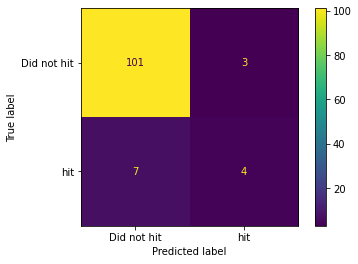

In [102]:
plot_confusion_matrix(clf_xgb,X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [103]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}

In [104]:
eval_set = [(X_test, y_test)]

In [105]:
gsearch1 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-aucpr:0.38956
[1]	validation_0-aucpr:0.42598
[2]	validation_0-aucpr:0.44812
[3]	validation_0-aucpr:0.46342
[4]	validation_0-aucpr:0.45160
[5]	validation_0-aucpr:0.44331
[6]	validation_0-aucpr:0.43841
[7]	validation_0-aucpr:0.40261
[8]	validation_0-aucpr:0.40242
[9]	validation_0-aucpr:0.41121
[10]	validation_0-aucpr:0.38942
[11]	validation_0-aucpr:0.39290
[12]	validation_0-aucpr:0.39732
[13]	validation_0-aucpr:0.41209
[14]	validation_0-aucpr:0.45811
[15]	validation_0-aucpr:0.46150
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-aucpr:0.36492
[1]	validation_0-aucpr:0.37110
[16]	validation_0-aucpr:0.49307
[2]	validation_0-aucpr:0.39234
[3]	validation_0-aucpr:0.38456
[17]	validation_0-aucpr:0.46125
[4]	validation_0-aucpr:0.4039

[40]	validation_0-aucpr:0.37057
[22]	validation_0-aucpr:0.31882
[49]	validation_0-aucpr:0.44920
[23]	validation_0-aucpr:0.31882
[50]	validation_0-aucpr:0.44233
[24]	validation_0-aucpr:0.31534
[25]	validation_0-aucpr:0.31410
[26]	validation_0-aucpr:0.31313
[51]	validation_0-aucpr:0.44028
[27]	validation_0-aucpr:0.31305
[52]	validation_0-aucpr:0.44057
[28]	validation_0-aucpr:0.31761
[29]	validation_0-aucpr:0.31728
[53]	validation_0-aucpr:0.44412
[54]	validation_0-aucpr:0.44944
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   0.4s
[0]	validation_0-aucpr:0.40252
[1]	validation_0-aucpr:0.41386
[2]	validation_0-aucpr:0.42266
[3]	validation_0-aucpr:0.41116
[4]	validation_0-aucpr:0.42382
[5]	validation_0-aucpr:0.40785
[6]	validation_0-aucpr:0.41511
[7]	validation_0-aucpr:0.41760
[8]	validation_0-aucpr:0.39247
[9]	validation_0-aucpr:0.41310
[10]	validation_0-aucpr:0.40130
[11]	validation_0-aucpr:0.40616
[12]	validation_0-aucpr:0.38482
[13]	

[25]	validation_0-aucpr:0.49034
[17]	validation_0-aucpr:0.49627
[26]	validation_0-aucpr:0.49034
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.39830
[20]	validation_0-aucpr:0.45123
[1]	validation_0-aucpr:0.34028
[21]	validation_0-aucpr:0.45123
[22]	validation_0-aucpr:0.44743
[2]	validation_0-aucpr:0.32773
[23]	validation_0-aucpr:0.44743
[3]	validation_0-aucpr:0.31656
[24]	validation_0-aucpr:0.44743
[4]	validation_0-aucpr:0.31656
[5]	validation_0-aucpr:0.31656
[6]	validation_0-aucpr:0.31656
[7]	validation_0-aucpr:0.31656
[8]	validation_0-aucpr:0.31656
[25]	validation_0-aucpr:0.44743
[26]	validation_0-aucpr:0.44654
[27]	validation_0-aucpr:0.44654
[27]	validation_0-aucpr:0.49226
[18]	validation_0-aucpr:0.50722
[19]	validation_0-aucpr:0.49157
[20]	validation_0-aucpr:0.49461
[21]	validation_0-aucpr:0.48957
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s

[24]	validation_0-aucpr:0.43989
[48]	validation_0-aucpr:0.40870
[25]	validation_0-aucpr:0.46860
[49]	validation_0-aucpr:0.41477
[50]	validation_0-aucpr:0.41006
[9]	validation_0-aucpr:0.53628
[10]	validation_0-aucpr:0.53628
[11]	validation_0-aucpr:0.54389
[12]	validation_0-aucpr:0.55807
[13]	validation_0-aucpr:0.55473
[14]	validation_0-aucpr:0.54399
[15]	validation_0-aucpr:0.54163
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-aucpr:0.16931
[31]	validation_0-aucpr:0.43534
[16]	validation_0-aucpr:0.54314
[17]	validation_0-aucpr:0.49846
[1]	validation_0-aucpr:0.21244
[32]	validation_0-aucpr:0.43534
[2]	validation_0-aucpr:0.21244
[33]	validation_0-aucpr:0.43358
[3]	validation_0-aucpr:0.22056
[34]	validation_0-aucpr:0.43358
[39]	validation_0-aucpr:0.43644
[35]	validation_0-aucpr:0.42892
[4]	validation_0-aucpr:0.22056
[40]	validation_0-aucpr:0.44007
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, s

[36]	validation_0-aucpr:0.37285
[35]	validation_0-aucpr:0.57636
[37]	validation_0-aucpr:0.36725
[38]	validation_0-aucpr:0.36550
[39]	validation_0-aucpr:0.36531
[36]	validation_0-aucpr:0.57300
[37]	validation_0-aucpr:0.57108
[40]	validation_0-aucpr:0.36531
[38]	validation_0-aucpr:0.57459
[83]	validation_0-aucpr:0.41699
[41]	validation_0-aucpr:0.36762
[39]	validation_0-aucpr:0.59834
[84]	validation_0-aucpr:0.41799
[85]	validation_0-aucpr:0.41799
[42]	validation_0-aucpr:0.36369
[40]	validation_0-aucpr:0.60252
[43]	validation_0-aucpr:0.37029
[86]	validation_0-aucpr:0.41799
[87]	validation_0-aucpr:0.41934
[88]	validation_0-aucpr:0.41934
[89]	validation_0-aucpr:0.41934
[90]	validation_0-aucpr:0.41799
[31]	validation_0-aucpr:0.33716
[91]	validation_0-aucpr:0.41934
[32]	validation_0-aucpr:0.33866
[13]	validation_0-aucpr:0.30793
[33]	validation_0-aucpr:0.33866
[14]	validation_0-aucpr:0.29385
[34]	validation_0-aucpr:0.34121
[15]	validation_0-aucpr:0.29376
[35]	validation_0-aucpr:0.34936
[36]	val

[49]	validation_0-aucpr:0.52047
[50]	validation_0-aucpr:0.51630
[51]	validation_0-aucpr:0.52645
[52]	validation_0-aucpr:0.52373
[53]	validation_0-aucpr:0.52234
[54]	validation_0-aucpr:0.57193
[55]	validation_0-aucpr:0.56687
[56]	validation_0-aucpr:0.57193
[57]	validation_0-aucpr:0.57464
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-aucpr:0.35189
[18]	validation_0-aucpr:0.38564
[19]	validation_0-aucpr:0.39669
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   0.7s
[0]	validation_0-aucpr:0.40252
[20]	validation_0-aucpr:0.40232
[21]	validation_0-aucpr:0.39590
[22]	validation_0-aucpr:0.40289
[1]	validation_0-aucpr:0.40252
[23]	validation_0-aucpr:0.40955
[24]	validation_0-aucpr:0.40304
[25]	validation_0-aucpr:0.40304
[2]	validation_0-aucpr:0.42495
[18]	validation_0-aucpr:0.42487
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=5; total ti

[22]	validation_0-aucpr:0.45089
[5]	validation_0-aucpr:0.43175
[25]	validation_0-aucpr:0.52176
[23]	validation_0-aucpr:0.44739
[26]	validation_0-aucpr:0.51796
[11]	validation_0-aucpr:0.38933
[24]	validation_0-aucpr:0.44655
[12]	validation_0-aucpr:0.38933
[25]	validation_0-aucpr:0.44576
[26]	validation_0-aucpr:0.44576
[27]	validation_0-aucpr:0.44780
[28]	validation_0-aucpr:0.44780
[13]	validation_0-aucpr:0.37641
[29]	validation_0-aucpr:0.44780
[14]	validation_0-aucpr:0.37641
[30]	validation_0-aucpr:0.44712
[15]	validation_0-aucpr:0.37641
[31]	validation_0-aucpr:0.44373
[16]	validation_0-aucpr:0.42186
[32]	validation_0-aucpr:0.43332
[33]	validation_0-aucpr:0.49386
[34]	validation_0-aucpr:0.49318
[17]	validation_0-aucpr:0.43058
[35]	validation_0-aucpr:0.49318
[27]	validation_0-aucpr:0.52330
[36]	validation_0-aucpr:0.49457
[6]	validation_0-aucpr:0.32001
[37]	validation_0-aucpr:0.49457
[7]	validation_0-aucpr:0.32853
[38]	validation_0-aucpr:0.49457
[8]	validation_0-aucpr:0.32001
[39]	validat

[88]	validation_0-aucpr:0.54275
[19]	validation_0-aucpr:0.56540
[20]	validation_0-aucpr:0.57600
[12]	validation_0-aucpr:0.37916
[13]	validation_0-aucpr:0.37411
[14]	validation_0-aucpr:0.38364
[21]	validation_0-aucpr:0.33443
[15]	validation_0-aucpr:0.39612
[22]	validation_0-aucpr:0.33509
[23]	validation_0-aucpr:0.33498
[16]	validation_0-aucpr:0.42810
[24]	validation_0-aucpr:0.33476
[17]	validation_0-aucpr:0.44273
[25]	validation_0-aucpr:0.33456
[26]	validation_0-aucpr:0.33456
[27]	validation_0-aucpr:0.39860
[21]	validation_0-aucpr:0.55595
[22]	validation_0-aucpr:0.56959
[37]	validation_0-aucpr:0.43377
[16]	validation_0-aucpr:0.29208
[23]	validation_0-aucpr:0.55290
[38]	validation_0-aucpr:0.43146
[17]	validation_0-aucpr:0.29370
[24]	validation_0-aucpr:0.55290
[18]	validation_0-aucpr:0.30006
[25]	validation_0-aucpr:0.53983
[19]	validation_0-aucpr:0.29559
[26]	validation_0-aucpr:0.56072
[20]	validation_0-aucpr:0.29351
[27]	validation_0-aucpr:0.56814
[21]	validation_0-aucpr:0.29559
[22]	val

[56]	validation_0-aucpr:0.51779
[27]	validation_0-aucpr:0.33141
[28]	validation_0-aucpr:0.34419
[15]	validation_0-aucpr:0.39715
[16]	validation_0-aucpr:0.39715
[17]	validation_0-aucpr:0.41157
[17]	validation_0-aucpr:0.55888
[18]	validation_0-aucpr:0.41499
[18]	validation_0-aucpr:0.56439
[19]	validation_0-aucpr:0.41213
[19]	validation_0-aucpr:0.55666
[20]	validation_0-aucpr:0.41213
[20]	validation_0-aucpr:0.50429
[21]	validation_0-aucpr:0.50681
[22]	validation_0-aucpr:0.50429
[23]	validation_0-aucpr:0.50174
[21]	validation_0-aucpr:0.41714
[24]	validation_0-aucpr:0.51638
[29]	validation_0-aucpr:0.33348
[30]	validation_0-aucpr:0.33141
[31]	validation_0-aucpr:0.34667
[32]	validation_0-aucpr:0.33249
[33]	validation_0-aucpr:0.34474
[34]	validation_0-aucpr:0.34644
[35]	validation_0-aucpr:0.34972
[25]	validation_0-aucpr:0.51638
[26]	validation_0-aucpr:0.50369
[27]	validation_0-aucpr:0.49894
[22]	validation_0-aucpr:0.42639
[28]	validation_0-aucpr:0.49739
[23]	validation_0-aucpr:0.42639
[29]	val

[21]	validation_0-aucpr:0.41775
[14]	validation_0-aucpr:0.41069
[22]	validation_0-aucpr:0.42329
[15]	validation_0-aucpr:0.42598
[23]	validation_0-aucpr:0.42583
[16]	validation_0-aucpr:0.44812
[17]	validation_0-aucpr:0.46342
[24]	validation_0-aucpr:0.42879
[6]	validation_0-aucpr:0.29814
[25]	validation_0-aucpr:0.42501
[26]	validation_0-aucpr:0.43037
[7]	validation_0-aucpr:0.29814
[8]	validation_0-aucpr:0.29744
[30]	validation_0-aucpr:0.43017
[9]	validation_0-aucpr:0.29744
[15]	validation_0-aucpr:0.37151
[31]	validation_0-aucpr:0.41749
[10]	validation_0-aucpr:0.29744
[16]	validation_0-aucpr:0.37151
[11]	validation_0-aucpr:0.30729
[41]	validation_0-aucpr:0.43141
[32]	validation_0-aucpr:0.42787
[17]	validation_0-aucpr:0.38444
[12]	validation_0-aucpr:0.29943
[42]	validation_0-aucpr:0.43702
[13]	validation_0-aucpr:0.31824
[14]	validation_0-aucpr:0.32144
[15]	validation_0-aucpr:0.32475
[43]	validation_0-aucpr:0.44055
[16]	validation_0-aucpr:0.32066
[44]	validation_0-aucpr:0.44232
[17]	validat

[38]	validation_0-aucpr:0.33144
[20]	validation_0-aucpr:0.39234
[39]	validation_0-aucpr:0.32908
[21]	validation_0-aucpr:0.39234
[66]	validation_0-aucpr:0.44500
[40]	validation_0-aucpr:0.32873
[67]	validation_0-aucpr:0.44568
[41]	validation_0-aucpr:0.32873
[42]	validation_0-aucpr:0.33066
[61]	validation_0-aucpr:0.43536
[43]	validation_0-aucpr:0.34185
[44]	validation_0-aucpr:0.34185
[62]	validation_0-aucpr:0.43613
[45]	validation_0-aucpr:0.34155
[68]	validation_0-aucpr:0.44795
[46]	validation_0-aucpr:0.34185
[63]	validation_0-aucpr:0.43445
[69]	validation_0-aucpr:0.44568
[64]	validation_0-aucpr:0.43445
[70]	validation_0-aucpr:0.44795
[65]	validation_0-aucpr:0.43445
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-aucpr:0.30199
[1]	validation_0-aucpr:0.32362
[2]	validation_0-aucpr:0.30830
[3]	validation_0-aucpr:0.30830
[71]	validation_0-aucpr:0.44924
[47]	validation_0-aucpr:0.34088
[3]	validation_0-aucpr:0.25999
[72]	

[3]	validation_0-aucpr:0.24018
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-aucpr:0.39375
[1]	validation_0-aucpr:0.40252
[4]	validation_0-aucpr:0.31463
[1]	validation_0-aucpr:0.32837
[2]	validation_0-aucpr:0.31788
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.2s
[0]	validation_0-aucpr:0.40662
[3]	validation_0-aucpr:0.30671
[1]	validation_0-aucpr:0.38848
[4]	validation_0-aucpr:0.30671
[2]	validation_0-aucpr:0.40519
[3]	validation_0-aucpr:0.38705
[4]	validation_0-aucpr:0.40519
[20]	validation_0-aucpr:0.46055
[21]	validation_0-aucpr:0.46055
[22]	validation_0-aucpr:0.46055
[23]	validation_0-aucpr:0.46055
[24]	validation_0-aucpr:0.49773
[25]	validation_0-aucpr:0.50478
[26]	validation_0-aucpr:0.50478
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.2s
[0]	validation_0-aucpr:0.38315
[27]	validation_0-aucpr:0.

[17]	validation_0-aucpr:0.31085
[18]	validation_0-aucpr:0.31085
[19]	validation_0-aucpr:0.31085
[20]	validation_0-aucpr:0.31217
[2]	validation_0-aucpr:0.39807
[21]	validation_0-aucpr:0.31217
[3]	validation_0-aucpr:0.39807
[22]	validation_0-aucpr:0.31217
[4]	validation_0-aucpr:0.39807
[23]	validation_0-aucpr:0.30128
[5]	validation_0-aucpr:0.39807
[6]	validation_0-aucpr:0.40451
[24]	validation_0-aucpr:0.30128
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.2s
[0]	validation_0-aucpr:0.16931
[1]	validation_0-aucpr:0.21244
[9]	validation_0-aucpr:0.25377
[2]	validation_0-aucpr:0.21244
[9]	validation_0-aucpr:0.28665
[7]	validation_0-aucpr:0.42009
[10]	validation_0-aucpr:0.25637
[3]	validation_0-aucpr:0.21244
[10]	validation_0-aucpr:0.28757
[11]	validation_0-aucpr:0.25637
[8]	validation_0-aucpr:0.42009
[4]	validation_0-aucpr:0.21244
[11]	validation_0-aucpr:0.27925
[12]	validation_0-aucpr:0.26492
[9]	validation_0-aucpr:0.42009
[5]	validati

[5]	validation_0-aucpr:0.25438
[10]	validation_0-aucpr:0.46861
[11]	validation_0-aucpr:0.46861
[12]	validation_0-aucpr:0.46861
[17]	validation_0-aucpr:0.41207
[6]	validation_0-aucpr:0.25658
[13]	validation_0-aucpr:0.46861
[18]	validation_0-aucpr:0.42124
[7]	validation_0-aucpr:0.25182
[14]	validation_0-aucpr:0.46861
[19]	validation_0-aucpr:0.43269
[8]	validation_0-aucpr:0.25793
[15]	validation_0-aucpr:0.46861
[20]	validation_0-aucpr:0.41706
[9]	validation_0-aucpr:0.25589
[16]	validation_0-aucpr:0.46861
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   0.4s
[0]	validation_0-aucpr:0.37536
[21]	validation_0-aucpr:0.41706
[17]	validation_0-aucpr:0.46861
[1]	validation_0-aucpr:0.32196
[18]	validation_0-aucpr:0.46861
[22]	validation_0-aucpr:0.42851
[2]	validation_0-aucpr:0.31341
[14]	validation_0-aucpr:0.29730
[23]	validation_0-aucpr:0.42514
[3]	validation_0-aucpr:0.32196
[15]	validation_0-aucpr:0.29265
[34]	validation_0-aucpr:0.42080
[16]	vali

[21]	validation_0-aucpr:0.36012
[26]	validation_0-aucpr:0.37633
[6]	validation_0-aucpr:0.26369
[22]	validation_0-aucpr:0.36012
[27]	validation_0-aucpr:0.37633
[7]	validation_0-aucpr:0.26369
[28]	validation_0-aucpr:0.37633
[8]	validation_0-aucpr:0.26369
[23]	validation_0-aucpr:0.35507
[24]	validation_0-aucpr:0.35442
[9]	validation_0-aucpr:0.26369
[7]	validation_0-aucpr:0.41732
[8]	validation_0-aucpr:0.41732
[9]	validation_0-aucpr:0.41732
[10]	validation_0-aucpr:0.41732
[16]	validation_0-aucpr:0.32132
[11]	validation_0-aucpr:0.41732
[17]	validation_0-aucpr:0.31277
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.36217
[12]	validation_0-aucpr:0.41732
[1]	validation_0-aucpr:0.39637
[13]	validation_0-aucpr:0.41732
[2]	validation_0-aucpr:0.42972
[3]	validation_0-aucpr:0.41985
[4]	validation_0-aucpr:0.41985
[5]	validation_0-aucpr:0.41985
[6]	validation_0-aucpr:0.41985
[7]	validation_0-aucpr:0.41985
[8]	validatio

[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.37066
[1]	validation_0-aucpr:0.36302
[4]	validation_0-aucpr:0.36663
[5]	validation_0-aucpr:0.36663
[6]	validation_0-aucpr:0.36663
[7]	validation_0-aucpr:0.36663
[8]	validation_0-aucpr:0.36663
[36]	validation_0-aucpr:0.31966
[9]	validation_0-aucpr:0.36663
[10]	validation_0-aucpr:0.36663
[37]	validation_0-aucpr:0.31966
[11]	validation_0-aucpr:0.36663
[38]	validation_0-aucpr:0.31966
[39]	validation_0-aucpr:0.31966
[40]	validation_0-aucpr:0.31966
[41]	validation_0-aucpr:0.31966
[26]	validation_0-aucpr:0.41837
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.42125
[27]	validation_0-aucpr:0.42080
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.26234
[1]	validation_0-aucpr:0.26244
[2]	validation_0-aucpr:0.26

[1]	validation_0-aucpr:0.41089
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-aucpr:0.37066
[1]	validation_0-aucpr:0.36936
[36]	validation_0-aucpr:0.52255
[2]	validation_0-aucpr:0.35683
[3]	validation_0-aucpr:0.36936
[4]	validation_0-aucpr:0.35683
[5]	validation_0-aucpr:0.36936
[6]	validation_0-aucpr:0.35683
[37]	validation_0-aucpr:0.52255
[38]	validation_0-aucpr:0.52953
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.37991
[39]	validation_0-aucpr:0.52255
[1]	validation_0-aucpr:0.33432
[6]	validation_0-aucpr:0.31463
[40]	validation_0-aucpr:0.52953
[7]	validation_0-aucpr:0.31153
[8]	validation_0-aucpr:0.31153
[9]	validation_0-aucpr:0.31153
[10]	validation_0-aucpr:0.31153
[2]	validation_0-aucpr:0.31467
[3]	validation_0-aucpr:0.32322
[11]	validation_0-aucpr:0.31153
[12]	validation_0-aucpr:0.31153
[41]	validation_0-aucpr:0.51614
[13]

[59]	validation_0-aucpr:0.42132
[22]	validation_0-aucpr:0.32803
[23]	validation_0-aucpr:0.32810
[24]	validation_0-aucpr:0.32794
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.2s
[0]	validation_0-aucpr:0.40252
[25]	validation_0-aucpr:0.32983
[26]	validation_0-aucpr:0.31251
[27]	validation_0-aucpr:0.30913
[37]	validation_0-aucpr:0.39452
[28]	validation_0-aucpr:0.30628
[29]	validation_0-aucpr:0.30913
[38]	validation_0-aucpr:0.40725
[39]	validation_0-aucpr:0.40875
[40]	validation_0-aucpr:0.40888
[41]	validation_0-aucpr:0.40469
[39]	validation_0-aucpr:0.37572
[40]	validation_0-aucpr:0.37776
[42]	validation_0-aucpr:0.41085
[43]	validation_0-aucpr:0.41870
[44]	validation_0-aucpr:0.42405
[41]	validation_0-aucpr:0.37947
[42]	validation_0-aucpr:0.38136
[37]	validation_0-aucpr:0.33475
[43]	validation_0-aucpr:0.37947
[44]	validation_0-aucpr:0.38391
[38]	validation_0-aucpr:0.33475
[45]	validation_0-aucpr:0.38136
[46]	validation_0-aucpr:0.38316
[

[4]	validation_0-aucpr:0.31656
[1]	validation_0-aucpr:0.27454
[2]	validation_0-aucpr:0.27454
[3]	validation_0-aucpr:0.27454
[5]	validation_0-aucpr:0.31656
[4]	validation_0-aucpr:0.27454
[9]	validation_0-aucpr:0.49910
[10]	validation_0-aucpr:0.49910
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.1s
[0]	validation_0-aucpr:0.36031
[11]	validation_0-aucpr:0.50442
[12]	validation_0-aucpr:0.50442
[1]	validation_0-aucpr:0.36031
[2]	validation_0-aucpr:0.36031
[3]	validation_0-aucpr:0.41505
[4]	validation_0-aucpr:0.41505
[13]	validation_0-aucpr:0.50442
[14]	validation_0-aucpr:0.49910
[15]	validation_0-aucpr:0.50442
[16]	validation_0-aucpr:0.51757
[6]	validation_0-aucpr:0.31656
[7]	validation_0-aucpr:0.31656
[8]	validation_0-aucpr:0.31656
[5]	validation_0-aucpr:0.27454
[9]	validation_0-aucpr:0.31656
[6]	validation_0-aucpr:0.27454
[10]	validation_0-aucpr:0.31656
[7]	validation_0-aucpr:0.27074
[8]	validation_0-aucpr:0.28123
[9]	validation_0-

[33]	validation_0-aucpr:0.39568
[17]	validation_0-aucpr:0.30373
[18]	validation_0-aucpr:0.32708
[19]	validation_0-aucpr:0.33369
[20]	validation_0-aucpr:0.33366
[73]	validation_0-aucpr:0.39696
[30]	validation_0-aucpr:0.25540
[29]	validation_0-aucpr:0.30883
[31]	validation_0-aucpr:0.25443
[32]	validation_0-aucpr:0.25429
[33]	validation_0-aucpr:0.25429
[30]	validation_0-aucpr:0.30772
[31]	validation_0-aucpr:0.31893
[26]	validation_0-aucpr:0.54442
[32]	validation_0-aucpr:0.31792
[33]	validation_0-aucpr:0.32128
[34]	validation_0-aucpr:0.31342
[27]	validation_0-aucpr:0.55267
[16]	validation_0-aucpr:0.26471
[28]	validation_0-aucpr:0.54428
[17]	validation_0-aucpr:0.26471
[29]	validation_0-aucpr:0.54428
[18]	validation_0-aucpr:0.26904
[30]	validation_0-aucpr:0.54428
[19]	validation_0-aucpr:0.26904
[20]	validation_0-aucpr:0.26904
[31]	validation_0-aucpr:0.54428
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-aucpr:0.40252
[

[11]	validation_0-aucpr:0.29277
[12]	validation_0-aucpr:0.29166
[13]	validation_0-aucpr:0.30682
[14]	validation_0-aucpr:0.31209
[15]	validation_0-aucpr:0.31320
[16]	validation_0-aucpr:0.32216
[65]	validation_0-aucpr:0.32889
[13]	validation_0-aucpr:0.45567
[66]	validation_0-aucpr:0.32889
[3]	validation_0-aucpr:0.30981
[14]	validation_0-aucpr:0.44936
[15]	validation_0-aucpr:0.45731
[67]	validation_0-aucpr:0.32856
[4]	validation_0-aucpr:0.30981
[16]	validation_0-aucpr:0.44211
[68]	validation_0-aucpr:0.32240
[17]	validation_0-aucpr:0.44211
[69]	validation_0-aucpr:0.32461
[18]	validation_0-aucpr:0.44211
[70]	validation_0-aucpr:0.32461
[19]	validation_0-aucpr:0.53392
[71]	validation_0-aucpr:0.32684
[20]	validation_0-aucpr:0.52762
[72]	validation_0-aucpr:0.32475
[5]	validation_0-aucpr:0.30981
[28]	validation_0-aucpr:0.43607
[73]	validation_0-aucpr:0.32475
[21]	validation_0-aucpr:0.52762
[6]	validation_0-aucpr:0.30981
[29]	validation_0-aucpr:0.43607
[22]	validation_0-aucpr:0.52762
[7]	validati

[13]	validation_0-aucpr:0.43726
[36]	validation_0-aucpr:0.31269
[2]	validation_0-aucpr:0.28333
[14]	validation_0-aucpr:0.43564
[3]	validation_0-aucpr:0.24263
[15]	validation_0-aucpr:0.37863
[4]	validation_0-aucpr:0.24700
[5]	validation_0-aucpr:0.24700
[6]	validation_0-aucpr:0.25670
[16]	validation_0-aucpr:0.37304
[7]	validation_0-aucpr:0.27000
[17]	validation_0-aucpr:0.38677
[18]	validation_0-aucpr:0.38857
[19]	validation_0-aucpr:0.38452
[17]	validation_0-aucpr:0.33586
[18]	validation_0-aucpr:0.33636
[19]	validation_0-aucpr:0.33817
[37]	validation_0-aucpr:0.31616
[38]	validation_0-aucpr:0.31616
[39]	validation_0-aucpr:0.31616
[40]	validation_0-aucpr:0.32090
[41]	validation_0-aucpr:0.32090
[42]	validation_0-aucpr:0.32090
[43]	validation_0-aucpr:0.32090
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   0.1s
[0]	validation_0-aucpr:0.26744
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time= 

[8]	validation_0-aucpr:0.52312
[47]	validation_0-aucpr:0.49586
[13]	validation_0-aucpr:0.30276
[48]	validation_0-aucpr:0.51131
[14]	validation_0-aucpr:0.30276
[49]	validation_0-aucpr:0.52988
[15]	validation_0-aucpr:0.31446
[9]	validation_0-aucpr:0.51614
[50]	validation_0-aucpr:0.52652
[51]	validation_0-aucpr:0.52652
[10]	validation_0-aucpr:0.52312
[11]	validation_0-aucpr:0.52312
[12]	validation_0-aucpr:0.52312
[13]	validation_0-aucpr:0.51614
[14]	validation_0-aucpr:0.52312
[22]	validation_0-aucpr:0.45104
[3]	validation_0-aucpr:0.27021
[23]	validation_0-aucpr:0.45104
[4]	validation_0-aucpr:0.27021
[24]	validation_0-aucpr:0.45104
[5]	validation_0-aucpr:0.28210
[25]	validation_0-aucpr:0.45104
[26]	validation_0-aucpr:0.45049
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.42784
[6]	validation_0-aucpr:0.28210
[27]	validation_0-aucpr:0.45292
[1]	validation_0-aucpr:0.43069
[7]	validation_0-aucpr:0.28210
[CV] END 

[19]	validation_0-aucpr:0.34772
[20]	validation_0-aucpr:0.37297
[21]	validation_0-aucpr:0.36748
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.35102
[1]	validation_0-aucpr:0.35102
[2]	validation_0-aucpr:0.41732
[40]	validation_0-aucpr:0.55436
[41]	validation_0-aucpr:0.55436
[3]	validation_0-aucpr:0.41732
[42]	validation_0-aucpr:0.55184
[4]	validation_0-aucpr:0.42365
[43]	validation_0-aucpr:0.55184
[5]	validation_0-aucpr:0.43735
[44]	validation_0-aucpr:0.54795
[49]	validation_0-aucpr:0.33520
[6]	validation_0-aucpr:0.43128
[45]	validation_0-aucpr:0.54543
[46]	validation_0-aucpr:0.55003
[7]	validation_0-aucpr:0.44539
[50]	validation_0-aucpr:0.33520
[3]	validation_0-aucpr:0.32322
[8]	validation_0-aucpr:0.47537
[4]	validation_0-aucpr:0.31467
[51]	validation_0-aucpr:0.39821
[52]	validation_0-aucpr:0.39821
[5]	validation_0-aucpr:0.31467
[53]	validation_0-aucpr:0.33709
[6]	validation_0-aucpr:0.32322
[54]	valida

[36]	validation_0-aucpr:0.33248
[11]	validation_0-aucpr:0.29843
[12]	validation_0-aucpr:0.29345
[13]	validation_0-aucpr:0.30126
[14]	validation_0-aucpr:0.36338
[15]	validation_0-aucpr:0.36230
[16]	validation_0-aucpr:0.36633
[17]	validation_0-aucpr:0.36721
[27]	validation_0-aucpr:0.61214
[28]	validation_0-aucpr:0.61228
[29]	validation_0-aucpr:0.60664
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.21406
[1]	validation_0-aucpr:0.24561
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   0.1s
[0]	validation_0-aucpr:0.30199
[5]	validation_0-aucpr:0.41136
[1]	validation_0-aucpr:0.35124
[6]	validation_0-aucpr:0.41638
[7]	validation_0-aucpr:0.42048
[37]	validation_0-aucpr:0.32838
[8]	validation_0-aucpr:0.43035
[9]	validation_0-aucpr:0.43283
[2]	validation_0-aucpr:0.35249
[10]	validation_0-aucpr:0.42872
[38]	validation_0-aucpr:0.32838
[3]	validation_0-aucpr:0.320

[43]	validation_0-aucpr:0.41673
[32]	validation_0-aucpr:0.62254
[33]	validation_0-aucpr:0.62407
[34]	validation_0-aucpr:0.62896
[44]	validation_0-aucpr:0.39771
[35]	validation_0-aucpr:0.62896
[36]	validation_0-aucpr:0.62896
[37]	validation_0-aucpr:0.62934
[1]	validation_0-aucpr:0.41550
[38]	validation_0-aucpr:0.63230
[2]	validation_0-aucpr:0.43887
[39]	validation_0-aucpr:0.62703
[40]	validation_0-aucpr:0.62741
[3]	validation_0-aucpr:0.43269
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-aucpr:0.38315
[4]	validation_0-aucpr:0.43220
[1]	validation_0-aucpr:0.41386
[1]	validation_0-aucpr:0.32861
[5]	validation_0-aucpr:0.43641
[2]	validation_0-aucpr:0.42266
[2]	validation_0-aucpr:0.32321
[6]	validation_0-aucpr:0.43690
[3]	validation_0-aucpr:0.41386
[7]	validation_0-aucpr:0.43732
[4]	validation_0-aucpr:0.42652
[5]	validation_0-aucpr:0.41116
[8]	validation_0-aucpr:0.42187
[6]	validation_0-aucpr:0.41511
[7]	validation_

[50]	validation_0-aucpr:0.40266
[51]	validation_0-aucpr:0.40613
[52]	validation_0-aucpr:0.40480
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.39830
[1]	validation_0-aucpr:0.34028
[2]	validation_0-aucpr:0.32773
[58]	validation_0-aucpr:0.58965
[3]	validation_0-aucpr:0.31656
[59]	validation_0-aucpr:0.58965
[60]	validation_0-aucpr:0.58544
[8]	validation_0-aucpr:0.49910
[61]	validation_0-aucpr:0.58544
[9]	validation_0-aucpr:0.50442
[10]	validation_0-aucpr:0.48804
[62]	validation_0-aucpr:0.55942
[63]	validation_0-aucpr:0.55942
[64]	validation_0-aucpr:0.55942
[11]	validation_0-aucpr:0.48502
[65]	validation_0-aucpr:0.55942
[12]	validation_0-aucpr:0.49565
[66]	validation_0-aucpr:0.55617
[13]	validation_0-aucpr:0.49565
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.23898
[14]	validation_0-aucpr:0.48804
[15]	validation_0-aucpr

[2]	validation_0-aucpr:0.25002
[36]	validation_0-aucpr:0.36281
[3]	validation_0-aucpr:0.25616
[37]	validation_0-aucpr:0.36101
[69]	validation_0-aucpr:0.57836
[70]	validation_0-aucpr:0.57836
[71]	validation_0-aucpr:0.57836
[72]	validation_0-aucpr:0.57836
[73]	validation_0-aucpr:0.57836
[27]	validation_0-aucpr:0.32797
[74]	validation_0-aucpr:0.57836
[22]	validation_0-aucpr:0.44035
[28]	validation_0-aucpr:0.32593
[75]	validation_0-aucpr:0.57836
[23]	validation_0-aucpr:0.42880
[29]	validation_0-aucpr:0.32434
[76]	validation_0-aucpr:0.57836
[30]	validation_0-aucpr:0.32300
[24]	validation_0-aucpr:0.49388
[77]	validation_0-aucpr:0.57836
[78]	validation_0-aucpr:0.57836
[25]	validation_0-aucpr:0.50901
[31]	validation_0-aucpr:0.32351
[79]	validation_0-aucpr:0.57836
[32]	validation_0-aucpr:0.33126
[26]	validation_0-aucpr:0.50485
[33]	validation_0-aucpr:0.33211
[34]	validation_0-aucpr:0.33211
[27]	validation_0-aucpr:0.42140
[28]	validation_0-aucpr:0.43105
[38]	validation_0-aucpr:0.36049
[4]	valida

[2]	validation_0-aucpr:0.30981
[10]	validation_0-aucpr:0.30715
[45]	validation_0-aucpr:0.31649
[3]	validation_0-aucpr:0.30981
[11]	validation_0-aucpr:0.30513
[4]	validation_0-aucpr:0.31024
[5]	validation_0-aucpr:0.31125
[6]	validation_0-aucpr:0.31822
[22]	validation_0-aucpr:0.44133
[15]	validation_0-aucpr:0.32804
[10]	validation_0-aucpr:0.53667
[23]	validation_0-aucpr:0.43545
[16]	validation_0-aucpr:0.33123
[24]	validation_0-aucpr:0.51060
[25]	validation_0-aucpr:0.49670
[17]	validation_0-aucpr:0.33877
[11]	validation_0-aucpr:0.52762
[26]	validation_0-aucpr:0.49594
[18]	validation_0-aucpr:0.37152
[12]	validation_0-aucpr:0.53740
[19]	validation_0-aucpr:0.36357
[13]	validation_0-aucpr:0.53740
[20]	validation_0-aucpr:0.36512
[14]	validation_0-aucpr:0.54118
[15]	validation_0-aucpr:0.53922
[16]	validation_0-aucpr:0.54485
[40]	validation_0-aucpr:0.53541
[21]	validation_0-aucpr:0.36598
[41]	validation_0-aucpr:0.52471
[22]	validation_0-aucpr:0.37242
[42]	validation_0-aucpr:0.52636
[43]	validati

[29]	validation_0-aucpr:0.44743
[63]	validation_0-aucpr:0.39053
[30]	validation_0-aucpr:0.45150
[64]	validation_0-aucpr:0.38990
[13]	validation_0-aucpr:0.47061
[65]	validation_0-aucpr:0.39053
[31]	validation_0-aucpr:0.45150
[32]	validation_0-aucpr:0.45150
[33]	validation_0-aucpr:0.45639
[66]	validation_0-aucpr:0.39053
[34]	validation_0-aucpr:0.45150
[67]	validation_0-aucpr:0.39053
[35]	validation_0-aucpr:0.45057
[68]	validation_0-aucpr:0.39053
[14]	validation_0-aucpr:0.46869
[69]	validation_0-aucpr:0.39053
[15]	validation_0-aucpr:0.46759
[70]	validation_0-aucpr:0.38930
[16]	validation_0-aucpr:0.46568
[71]	validation_0-aucpr:0.39193
[17]	validation_0-aucpr:0.47177
[8]	validation_0-aucpr:0.31942
[18]	validation_0-aucpr:0.46568
[9]	validation_0-aucpr:0.32387
[10]	validation_0-aucpr:0.32387
[11]	validation_0-aucpr:0.32387
[12]	validation_0-aucpr:0.40211
[13]	validation_0-aucpr:0.41728
[14]	validation_0-aucpr:0.41026
[32]	validation_0-aucpr:0.50213
[33]	validation_0-aucpr:0.50213
[19]	valid

[43]	validation_0-aucpr:0.40647
[44]	validation_0-aucpr:0.40451
[45]	validation_0-aucpr:0.40451
[11]	validation_0-aucpr:0.35012
[46]	validation_0-aucpr:0.40451
[47]	validation_0-aucpr:0.40912
[12]	validation_0-aucpr:0.36917
[13]	validation_0-aucpr:0.37371
[14]	validation_0-aucpr:0.37779
[15]	validation_0-aucpr:0.37365
[16]	validation_0-aucpr:0.38807
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   0.4s
[0]	validation_0-aucpr:0.21098
[1]	validation_0-aucpr:0.26684
[2]	validation_0-aucpr:0.32920
[17]	validation_0-aucpr:0.38807
[18]	validation_0-aucpr:0.45108
[19]	validation_0-aucpr:0.45108
[20]	validation_0-aucpr:0.46544
[21]	validation_0-aucpr:0.47348
[22]	validation_0-aucpr:0.39737
[23]	validation_0-aucpr:0.39705
[24]	validation_0-aucpr:0.39721
[25]	validation_0-aucpr:0.38557
[3]	validation_0-aucpr:0.31417
[4]	validation_0-aucpr:0.31161
[5]	validation_0-aucpr:0.29125
[6]	validation_0-aucpr:0.26729
[7]	validation_0-aucpr:0.27189
[8]	

[65]	validation_0-aucpr:0.35349
[30]	validation_0-aucpr:0.42107
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.26234
[66]	validation_0-aucpr:0.35349
[31]	validation_0-aucpr:0.42758
[67]	validation_0-aucpr:0.35349
[1]	validation_0-aucpr:0.25433
[68]	validation_0-aucpr:0.35349
[32]	validation_0-aucpr:0.43047
[69]	validation_0-aucpr:0.35349
[33]	validation_0-aucpr:0.43458
[70]	validation_0-aucpr:0.35349
[34]	validation_0-aucpr:0.50830
[35]	validation_0-aucpr:0.51059
[36]	validation_0-aucpr:0.50991
[37]	validation_0-aucpr:0.51472
[12]	validation_0-aucpr:0.28494
[36]	validation_0-aucpr:0.31642
[13]	validation_0-aucpr:0.28677
[37]	validation_0-aucpr:0.32713
[14]	validation_0-aucpr:0.28677
[38]	validation_0-aucpr:0.32955
[15]	validation_0-aucpr:0.29167
[39]	validation_0-aucpr:0.32955
[40]	validation_0-aucpr:0.31755
[41]	validation_0-aucpr:0.31755
[42]	validation_0-aucpr:0.31755
[43]	validation_0-aucpr:0.31755


[74]	validation_0-aucpr:0.47064
[21]	validation_0-aucpr:0.42293
[12]	validation_0-aucpr:0.41548
[13]	validation_0-aucpr:0.39994
[13]	validation_0-aucpr:0.41253
[14]	validation_0-aucpr:0.41436
[14]	validation_0-aucpr:0.41548
[15]	validation_0-aucpr:0.41844
[15]	validation_0-aucpr:0.43036
[16]	validation_0-aucpr:0.43036
[17]	validation_0-aucpr:0.44322
[18]	validation_0-aucpr:0.45034
[19]	validation_0-aucpr:0.45427
[16]	validation_0-aucpr:0.41928
[40]	validation_0-aucpr:0.40525
[41]	validation_0-aucpr:0.40695
[42]	validation_0-aucpr:0.40092
[17]	validation_0-aucpr:0.41928
[43]	validation_0-aucpr:0.40779
[18]	validation_0-aucpr:0.42094
[44]	validation_0-aucpr:0.40456
[45]	validation_0-aucpr:0.40456
[46]	validation_0-aucpr:0.39991
[19]	validation_0-aucpr:0.46163
[47]	validation_0-aucpr:0.39991
[20]	validation_0-aucpr:0.46318
[48]	validation_0-aucpr:0.40017
[21]	validation_0-aucpr:0.46318
[16]	validation_0-aucpr:0.37596
[22]	validation_0-aucpr:0.46694
[17]	validation_0-aucpr:0.36944
[23]	val

[50]	validation_0-aucpr:0.42690
[55]	validation_0-aucpr:0.42532
[11]	validation_0-aucpr:0.29732
[21]	validation_0-aucpr:0.44235
[56]	validation_0-aucpr:0.42866
[51]	validation_0-aucpr:0.41180
[12]	validation_0-aucpr:0.30585
[57]	validation_0-aucpr:0.42866
[22]	validation_0-aucpr:0.43885
[52]	validation_0-aucpr:0.41279
[13]	validation_0-aucpr:0.32742
[58]	validation_0-aucpr:0.41227
[23]	validation_0-aucpr:0.44641
[34]	validation_0-aucpr:0.51730
[14]	validation_0-aucpr:0.32742
[59]	validation_0-aucpr:0.41227
[35]	validation_0-aucpr:0.51730
[36]	validation_0-aucpr:0.51810
[37]	validation_0-aucpr:0.51810
[38]	validation_0-aucpr:0.51800
[39]	validation_0-aucpr:0.51800
[40]	validation_0-aucpr:0.51519
[51]	validation_0-aucpr:0.46753
[52]	validation_0-aucpr:0.47151
[53]	validation_0-aucpr:0.47151
[22]	validation_0-aucpr:0.42889
[54]	validation_0-aucpr:0.47151
[18]	validation_0-aucpr:0.44498
[23]	validation_0-aucpr:0.44175
[55]	validation_0-aucpr:0.46077
[19]	validation_0-aucpr:0.45414
[24]	val

[2]	validation_0-aucpr:0.33442
[3]	validation_0-aucpr:0.33442
[4]	validation_0-aucpr:0.34987
[5]	validation_0-aucpr:0.33442
[6]	validation_0-aucpr:0.33442
[7]	validation_0-aucpr:0.34987
[8]	validation_0-aucpr:0.34987
[20]	validation_0-aucpr:0.25493
[21]	validation_0-aucpr:0.25959
[22]	validation_0-aucpr:0.25959
[23]	validation_0-aucpr:0.25261
[9]	validation_0-aucpr:0.33442
[10]	validation_0-aucpr:0.33442
[11]	validation_0-aucpr:0.33442
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   0.4s
[0]	validation_0-aucpr:0.43667
[12]	validation_0-aucpr:0.34987
[13]	validation_0-aucpr:0.34987
[14]	validation_0-aucpr:0.34987
[1]	validation_0-aucpr:0.43667
[15]	validation_0-aucpr:0.33442
[2]	validation_0-aucpr:0.43667
[16]	validation_0-aucpr:0.33442
[3]	validation_0-aucpr:0.43667
[4]	validation_0-aucpr:0.43667
[5]	validation_0-aucpr:0.43667
[6]	validation_0-aucpr:0.43667
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scal

[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.3s
[0]	validation_0-aucpr:0.39311
[1]	validation_0-aucpr:0.46334
[2]	validation_0-aucpr:0.46334
[3]	validation_0-aucpr:0.46334
[4]	validation_0-aucpr:0.46334
[5]	validation_0-aucpr:0.46334
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.39830
[6]	validation_0-aucpr:0.46334
[36]	validation_0-aucpr:0.46330
[4]	validation_0-aucpr:0.37375
[11]	validation_0-aucpr:0.31153
[37]	validation_0-aucpr:0.46330
[5]	validation_0-aucpr:0.37375
[6]	validation_0-aucpr:0.37375
[38]	validation_0-aucpr:0.46330
[12]	validation_0-aucpr:0.31153
[7]	validation_0-aucpr:0.37375
[39]	validation_0-aucpr:0.46330
[13]	validation_0-aucpr:0.31153
[8]	validation_0-aucpr:0.37375
[40]	validation_0-aucpr:0.46330
[14]	validation_0-aucpr:0.31153
[9]	validation_0-aucpr:0.37375
[41]	validation_0-aucpr:0.46330
[15]	validation_0-aucpr:0.31153


[3]	validation_0-aucpr:0.21244
[4]	validation_0-aucpr:0.21244
[4]	validation_0-aucpr:0.25164
[5]	validation_0-aucpr:0.25377
[5]	validation_0-aucpr:0.21244
[6]	validation_0-aucpr:0.21244
[7]	validation_0-aucpr:0.21244
[8]	validation_0-aucpr:0.21244
[6]	validation_0-aucpr:0.25377
[7]	validation_0-aucpr:0.25377
[8]	validation_0-aucpr:0.25377
[9]	validation_0-aucpr:0.25377
[10]	validation_0-aucpr:0.25637
[5]	validation_0-aucpr:0.29840
[6]	validation_0-aucpr:0.29840
[18]	validation_0-aucpr:0.31085
[19]	validation_0-aucpr:0.31085
[20]	validation_0-aucpr:0.31217
[7]	validation_0-aucpr:0.30384
[21]	validation_0-aucpr:0.31217
[22]	validation_0-aucpr:0.31217
[23]	validation_0-aucpr:0.30128
[24]	validation_0-aucpr:0.30128
[8]	validation_0-aucpr:0.25600
[9]	validation_0-aucpr:0.26153
[10]	validation_0-aucpr:0.25760
[4]	validation_0-aucpr:0.37505
[1]	validation_0-aucpr:0.42438
[5]	validation_0-aucpr:0.37505
[11]	validation_0-aucpr:0.40515
[2]	validation_0-aucpr:0.37934
[6]	validation_0-aucpr:0.3750

[29]	validation_0-aucpr:0.42652
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   0.2s
[0]	validation_0-aucpr:0.33272
[29]	validation_0-aucpr:0.26471
[30]	validation_0-aucpr:0.42652
[1]	validation_0-aucpr:0.28203
[30]	validation_0-aucpr:0.26471
[31]	validation_0-aucpr:0.42652
[32]	validation_0-aucpr:0.42652
[31]	validation_0-aucpr:0.26471
[33]	validation_0-aucpr:0.42652
[32]	validation_0-aucpr:0.26471
[33]	validation_0-aucpr:0.26471
[2]	validation_0-aucpr:0.27954
[34]	validation_0-aucpr:0.26471
[3]	validation_0-aucpr:0.25911
[35]	validation_0-aucpr:0.26471
[4]	validation_0-aucpr:0.25658
[5]	validation_0-aucpr:0.25438
[18]	validation_0-aucpr:0.29265
[4]	validation_0-aucpr:0.24917
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   0.2s
[0]	validation_0-aucpr:0.43069
[5]	validation_0-aucpr:0.24917
[27]	validation_0-aucpr:0.43866
[6]	validation_0-aucpr:0.24917
[1]	validation_0-aucpr:0.430

[13]	validation_0-aucpr:0.31153
[14]	validation_0-aucpr:0.31153
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.23898
[6]	validation_0-aucpr:0.41089
[15]	validation_0-aucpr:0.31153
[16]	validation_0-aucpr:0.31153
[7]	validation_0-aucpr:0.41089
[17]	validation_0-aucpr:0.31153
[8]	validation_0-aucpr:0.41089
[18]	validation_0-aucpr:0.31153
[19]	validation_0-aucpr:0.31153
[20]	validation_0-aucpr:0.38754
[21]	validation_0-aucpr:0.39406
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   0.1s
[0]	validation_0-aucpr:0.36031
[22]	validation_0-aucpr:0.36992
[23]	validation_0-aucpr:0.36992
[9]	validation_0-aucpr:0.41089
[24]	validation_0-aucpr:0.36992
[10]	validation_0-aucpr:0.41089
[25]	validation_0-aucpr:0.37633
[26]	validation_0-aucpr:0.37633
[11]	validation_0-aucpr:0.41089
[12]	validation_0-aucpr:0.41089
[13]	validation_0-aucpr:0.41089
[4]	validation_0-auc

[6]	validation_0-aucpr:0.31253
[2]	validation_0-aucpr:0.25335
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   0.1s
[0]	validation_0-aucpr:0.31463
[3]	validation_0-aucpr:0.46549
[7]	validation_0-aucpr:0.31797
[1]	validation_0-aucpr:0.38241
[4]	validation_0-aucpr:0.44826
[8]	validation_0-aucpr:0.31797
[3]	validation_0-aucpr:0.25164
[2]	validation_0-aucpr:0.37505
[4]	validation_0-aucpr:0.25164
[3]	validation_0-aucpr:0.37505
[9]	validation_0-aucpr:0.31253
[4]	validation_0-aucpr:0.37505
[10]	validation_0-aucpr:0.31253
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.20002
[1]	validation_0-aucpr:0.28031
[2]	validation_0-aucpr:0.29358
[3]	validation_0-aucpr:0.29358
[4]	validation_0-aucpr:0.29358
[11]	validation_0-aucpr:0.31253
[12]	validation_0-aucpr:0.31797
[5]	validation_0-aucpr:0.25377
[13]	validation_0-aucpr:0.31797
[6]	validation_0-aucpr:0.25377
[7

[45]	validation_0-aucpr:0.43755
[46]	validation_0-aucpr:0.43755
[47]	validation_0-aucpr:0.44702
[48]	validation_0-aucpr:0.44702
[49]	validation_0-aucpr:0.44702
[50]	validation_0-aucpr:0.44702
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.1s
[0]	validation_0-aucpr:0.38315
[1]	validation_0-aucpr:0.39365
[2]	validation_0-aucpr:0.37375
[3]	validation_0-aucpr:0.37375
[13]	validation_0-aucpr:0.40252
[14]	validation_0-aucpr:0.40252
[13]	validation_0-aucpr:0.31472
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   0.2s
[0]	validation_0-aucpr:0.24018
[1]	validation_0-aucpr:0.24018
[2]	validation_0-aucpr:0.24018
[15]	validation_0-aucpr:0.40252
[3]	validation_0-aucpr:0.24018
[16]	validation_0-aucpr:0.40252
[17]	validation_0-aucpr:0.40252
[4]	validation_0-aucpr:0.31463
[5]	validation_0-aucpr:0.31463
[6]	validation_0-aucpr:0.31463
[14]	validation_0-aucpr:0.31472
[15]	validation_0-aucpr:0

[35]	validation_0-aucpr:0.33610
[36]	validation_0-aucpr:0.33610
[37]	validation_0-aucpr:0.33212
[39]	validation_0-aucpr:0.37146
[5]	validation_0-aucpr:0.25655
[6]	validation_0-aucpr:0.28634
[40]	validation_0-aucpr:0.37401
[7]	validation_0-aucpr:0.27328
[41]	validation_0-aucpr:0.37401
[8]	validation_0-aucpr:0.27328
[42]	validation_0-aucpr:0.37146
[9]	validation_0-aucpr:0.31669
[43]	validation_0-aucpr:0.37401
[10]	validation_0-aucpr:0.31141
[44]	validation_0-aucpr:0.37401
[11]	validation_0-aucpr:0.31379
[45]	validation_0-aucpr:0.37401
[12]	validation_0-aucpr:0.32581
[46]	validation_0-aucpr:0.37590
[47]	validation_0-aucpr:0.37407
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.2s
[0]	validation_0-aucpr:0.38315
[1]	validation_0-aucpr:0.32861
[2]	validation_0-aucpr:0.32321
[3]	validation_0-aucpr:0.31623
[4]	validation_0-aucpr:0.29803
[7]	validation_0-aucpr:0.41386
[8]	validation_0-aucpr:0.42652
[4]	validation_0-aucpr:0.43220
[9]	valida

[21]	validation_0-aucpr:0.31757
[22]	validation_0-aucpr:0.31757
[6]	validation_0-aucpr:0.37335
[23]	validation_0-aucpr:0.32503
[24]	validation_0-aucpr:0.32503
[7]	validation_0-aucpr:0.37025
[25]	validation_0-aucpr:0.32503
[9]	validation_0-aucpr:0.40627
[8]	validation_0-aucpr:0.37894
[26]	validation_0-aucpr:0.32499
[10]	validation_0-aucpr:0.40345
[12]	validation_0-aucpr:0.31993
[9]	validation_0-aucpr:0.37307
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.23694
[13]	validation_0-aucpr:0.31390
[10]	validation_0-aucpr:0.38234
[1]	validation_0-aucpr:0.26684
[11]	validation_0-aucpr:0.35324
[12]	validation_0-aucpr:0.33625
[2]	validation_0-aucpr:0.28333
[13]	validation_0-aucpr:0.33089
[3]	validation_0-aucpr:0.26897
[14]	validation_0-aucpr:0.32888
[15]	validation_0-aucpr:0.33333
[16]	validation_0-aucpr:0.33333
[17]	validation_0-aucpr:0.33924
[18]	validation_0-aucpr:0.33376
[11]	validation_0-aucpr:0.40614
[14]

[28]	validation_0-aucpr:0.33989
[37]	validation_0-aucpr:0.37431
[29]	validation_0-aucpr:0.32946
[38]	validation_0-aucpr:0.37431
[30]	validation_0-aucpr:0.32661
[39]	validation_0-aucpr:0.37343
[31]	validation_0-aucpr:0.33311
[40]	validation_0-aucpr:0.37343
[27]	validation_0-aucpr:0.27194
[28]	validation_0-aucpr:0.27415
[41]	validation_0-aucpr:0.37662
[42]	validation_0-aucpr:0.37762
[29]	validation_0-aucpr:0.26982
[43]	validation_0-aucpr:0.37662
[44]	validation_0-aucpr:0.37871
[30]	validation_0-aucpr:0.26982
[31]	validation_0-aucpr:0.27466
[17]	validation_0-aucpr:0.33771
[17]	validation_0-aucpr:0.26471
[18]	validation_0-aucpr:0.26904
[28]	validation_0-aucpr:0.54699
[19]	validation_0-aucpr:0.26904
[37]	validation_0-aucpr:0.51392
[29]	validation_0-aucpr:0.53860
[20]	validation_0-aucpr:0.26904
[30]	validation_0-aucpr:0.54274
[21]	validation_0-aucpr:0.26360
[31]	validation_0-aucpr:0.54043
[22]	validation_0-aucpr:0.27544
[32]	validation_0-aucpr:0.40763
[33]	validation_0-aucpr:0.40949
[23]	val

[2]	validation_0-aucpr:0.41089
[48]	validation_0-aucpr:0.41259
[49]	validation_0-aucpr:0.40963
[3]	validation_0-aucpr:0.41089
[50]	validation_0-aucpr:0.40570
[4]	validation_0-aucpr:0.41089
[51]	validation_0-aucpr:0.40570
[1]	validation_0-aucpr:0.33415
[2]	validation_0-aucpr:0.31244
[3]	validation_0-aucpr:0.31656
[4]	validation_0-aucpr:0.31656
[5]	validation_0-aucpr:0.31656
[6]	validation_0-aucpr:0.32132
[7]	validation_0-aucpr:0.31277
[8]	validation_0-aucpr:0.32132
[9]	validation_0-aucpr:0.32132
[5]	validation_0-aucpr:0.40975
[6]	validation_0-aucpr:0.45082
[7]	validation_0-aucpr:0.46669
[36]	validation_0-aucpr:0.42616
[10]	validation_0-aucpr:0.32132
[37]	validation_0-aucpr:0.42616
[11]	validation_0-aucpr:0.32132
[38]	validation_0-aucpr:0.41495
[12]	validation_0-aucpr:0.31942
[39]	validation_0-aucpr:0.42064
[13]	validation_0-aucpr:0.31296
[14]	validation_0-aucpr:0.31296
[40]	validation_0-aucpr:0.42940
[15]	validation_0-aucpr:0.32412
[16]	validation_0-aucpr:0.31500
[17]	validation_0-aucpr

[34]	validation_0-aucpr:0.55473
[49]	validation_0-aucpr:0.38957
[2]	validation_0-aucpr:0.32923
[35]	validation_0-aucpr:0.59652
[3]	validation_0-aucpr:0.32923
[36]	validation_0-aucpr:0.59652
[4]	validation_0-aucpr:0.30806
[37]	validation_0-aucpr:0.60066
[38]	validation_0-aucpr:0.52589
[39]	validation_0-aucpr:0.52589
[5]	validation_0-aucpr:0.30393
[6]	validation_0-aucpr:0.29895
[7]	validation_0-aucpr:0.29431
[8]	validation_0-aucpr:0.29835
[18]	validation_0-aucpr:0.40531
[9]	validation_0-aucpr:0.30291
[19]	validation_0-aucpr:0.41085
[20]	validation_0-aucpr:0.40387
[21]	validation_0-aucpr:0.40976
[22]	validation_0-aucpr:0.40929
[5]	validation_0-aucpr:0.41241
[6]	validation_0-aucpr:0.43866
[7]	validation_0-aucpr:0.43279
[8]	validation_0-aucpr:0.44425
[9]	validation_0-aucpr:0.43866
[10]	validation_0-aucpr:0.43671
[11]	validation_0-aucpr:0.44816
[50]	validation_0-aucpr:0.38459
[12]	validation_0-aucpr:0.44816
[51]	validation_0-aucpr:0.38459
[52]	validation_0-aucpr:0.38957
[53]	validation_0-auc

[59]	validation_0-aucpr:0.42316
[5]	validation_0-aucpr:0.31392
[7]	validation_0-aucpr:0.36122
[8]	validation_0-aucpr:0.36705
[60]	validation_0-aucpr:0.42316
[6]	validation_0-aucpr:0.30540
[61]	validation_0-aucpr:0.42486
[9]	validation_0-aucpr:0.36404
[10]	validation_0-aucpr:0.37218
[62]	validation_0-aucpr:0.42486
[11]	validation_0-aucpr:0.35937
[7]	validation_0-aucpr:0.31392
[12]	validation_0-aucpr:0.35937
[8]	validation_0-aucpr:0.30540
[63]	validation_0-aucpr:0.42486
[9]	validation_0-aucpr:0.31392
[64]	validation_0-aucpr:0.42486
[10]	validation_0-aucpr:0.31392
[11]	validation_0-aucpr:0.30540
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-aucpr:0.37201
[12]	validation_0-aucpr:0.31392
[1]	validation_0-aucpr:0.37819
[13]	validation_0-aucpr:0.31282
[2]	validation_0-aucpr:0.39401
[14]	validation_0-aucpr:0.32134
[3]	validation_0-aucpr:0.38331
[16]	validation_0-aucpr:0.29587
[17]	validation_0-aucpr:0.29587
[18]	v

[23]	validation_0-aucpr:0.34765
[24]	validation_0-aucpr:0.35158
[5]	validation_0-aucpr:0.33312
[25]	validation_0-aucpr:0.34445
[26]	validation_0-aucpr:0.34655
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.32884
[1]	validation_0-aucpr:0.34634
[27]	validation_0-aucpr:0.34276
[6]	validation_0-aucpr:0.33615
[41]	validation_0-aucpr:0.62630
[42]	validation_0-aucpr:0.63026
[43]	validation_0-aucpr:0.63026
[44]	validation_0-aucpr:0.62525
[45]	validation_0-aucpr:0.62989
[46]	validation_0-aucpr:0.62989
[47]	validation_0-aucpr:0.62989
[48]	validation_0-aucpr:0.62989
[49]	validation_0-aucpr:0.62989
[2]	validation_0-aucpr:0.29522
[3]	validation_0-aucpr:0.30923
[4]	validation_0-aucpr:0.32033
[5]	validation_0-aucpr:0.28602
[6]	validation_0-aucpr:0.29235
[7]	validation_0-aucpr:0.30266
[7]	validation_0-aucpr:0.35204
[8]	validation_0-aucpr:0.33622
[9]	validation_0-aucpr:0.33245
[CV] END gamma=1.0, learning_rate=0.1, max_d

[15]	validation_0-aucpr:0.46632
[16]	validation_0-aucpr:0.46632
[45]	validation_0-aucpr:0.47075
[24]	validation_0-aucpr:0.53905
[17]	validation_0-aucpr:0.46559
[46]	validation_0-aucpr:0.50061
[25]	validation_0-aucpr:0.53905
[18]	validation_0-aucpr:0.47609
[26]	validation_0-aucpr:0.54042
[19]	validation_0-aucpr:0.47609
[47]	validation_0-aucpr:0.50061
[27]	validation_0-aucpr:0.53877
[28]	validation_0-aucpr:0.53376
[48]	validation_0-aucpr:0.44006
[29]	validation_0-aucpr:0.52852
[49]	validation_0-aucpr:0.44006
[30]	validation_0-aucpr:0.52090
[50]	validation_0-aucpr:0.44006
[31]	validation_0-aucpr:0.53576
[51]	validation_0-aucpr:0.44006
[44]	validation_0-aucpr:0.52286
[52]	validation_0-aucpr:0.44357
[45]	validation_0-aucpr:0.52440
[46]	validation_0-aucpr:0.52440
[47]	validation_0-aucpr:0.52440
[48]	validation_0-aucpr:0.52440
[49]	validation_0-aucpr:0.52440
[50]	validation_0-aucpr:0.52804
[51]	validation_0-aucpr:0.52804
[52]	validation_0-aucpr:0.52804
[23]	validation_0-aucpr:0.42799
[24]	val

[62]	validation_0-aucpr:0.51268
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-aucpr:0.37527
[48]	validation_0-aucpr:0.47192
[1]	validation_0-aucpr:0.38477
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.19355
[2]	validation_0-aucpr:0.38948
[1]	validation_0-aucpr:0.23867
[3]	validation_0-aucpr:0.38368
[2]	validation_0-aucpr:0.23867
[4]	validation_0-aucpr:0.38228
[4]	validation_0-aucpr:0.27450
[5]	validation_0-aucpr:0.41702
[5]	validation_0-aucpr:0.30192
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-aucpr:0.36561
[6]	validation_0-aucpr:0.27824
[1]	validation_0-aucpr:0.39807
[7]	validation_0-aucpr:0.30526
[2]	validation_0-aucpr:0.38959
[8]	validation_0-aucpr:0.32084
[3]	validation_0-aucpr:0.43302
[6]	validation_0-aucpr:0.39731
[9]	validation_0-aucpr:

[25]	validation_0-aucpr:0.31083
[26]	validation_0-aucpr:0.31083
[27]	validation_0-aucpr:0.30681
[28]	validation_0-aucpr:0.29931
[29]	validation_0-aucpr:0.31401
[30]	validation_0-aucpr:0.30961
[31]	validation_0-aucpr:0.30961
[11]	validation_0-aucpr:0.41534
[12]	validation_0-aucpr:0.41279
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-aucpr:0.37066
[13]	validation_0-aucpr:0.42324
[49]	validation_0-aucpr:0.38211
[43]	validation_0-aucpr:0.49631
[14]	validation_0-aucpr:0.42737
[50]	validation_0-aucpr:0.38211
[1]	validation_0-aucpr:0.33169
[44]	validation_0-aucpr:0.49631
[51]	validation_0-aucpr:0.38211
[15]	validation_0-aucpr:0.42199
[2]	validation_0-aucpr:0.32204
[45]	validation_0-aucpr:0.49631
[52]	validation_0-aucpr:0.38211
[16]	validation_0-aucpr:0.41302
[3]	validation_0-aucpr:0.29840
[53]	validation_0-aucpr:0.38211
[17]	validation_0-aucpr:0.41598
[5]	validation_0-aucpr:0.42252
[18]	validation_0-aucpr:0.42285
[54]

[19]	validation_0-aucpr:0.42411
[20]	validation_0-aucpr:0.42090
[21]	validation_0-aucpr:0.41626
[22]	validation_0-aucpr:0.48711
[4]	validation_0-aucpr:0.31024
[5]	validation_0-aucpr:0.31125
[36]	validation_0-aucpr:0.55598
[26]	validation_0-aucpr:0.34911
[37]	validation_0-aucpr:0.55598
[38]	validation_0-aucpr:0.51912
[27]	validation_0-aucpr:0.35476
[39]	validation_0-aucpr:0.52556
[28]	validation_0-aucpr:0.34636
[40]	validation_0-aucpr:0.52323
[41]	validation_0-aucpr:0.52556
[42]	validation_0-aucpr:0.52556
[16]	validation_0-aucpr:0.34975
[43]	validation_0-aucpr:0.52556
[29]	validation_0-aucpr:0.34039
[17]	validation_0-aucpr:0.35589
[30]	validation_0-aucpr:0.34039
[18]	validation_0-aucpr:0.35589
[31]	validation_0-aucpr:0.34039
[19]	validation_0-aucpr:0.36383
[32]	validation_0-aucpr:0.34039
[20]	validation_0-aucpr:0.36383
[21]	validation_0-aucpr:0.36383
[22]	validation_0-aucpr:0.36386
[33]	validation_0-aucpr:0.34039
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_po

[50]	validation_0-aucpr:0.60852
[51]	validation_0-aucpr:0.60976
[52]	validation_0-aucpr:0.60976
[53]	validation_0-aucpr:0.60817
[63]	validation_0-aucpr:0.49939
[54]	validation_0-aucpr:0.57398
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   0.2s
[0]	validation_0-aucpr:0.37527
[1]	validation_0-aucpr:0.39420
[2]	validation_0-aucpr:0.39404
[3]	validation_0-aucpr:0.36208
[40]	validation_0-aucpr:0.47980
[4]	validation_0-aucpr:0.33504
[44]	validation_0-aucpr:0.55546
[45]	validation_0-aucpr:0.55606
[46]	validation_0-aucpr:0.55546
[47]	validation_0-aucpr:0.55546
[48]	validation_0-aucpr:0.55546
[49]	validation_0-aucpr:0.55546
[50]	validation_0-aucpr:0.55382
[51]	validation_0-aucpr:0.55546
[41]	validation_0-aucpr:0.47980
[19]	validation_0-aucpr:0.44562
[20]	validation_0-aucpr:0.44403
[21]	validation_0-aucpr:0.44904
[22]	validation_0-aucpr:0.43350
[55]	validation_0-aucpr:0.57358
[23]	validation_0-aucpr:0.43649
[24]	validation_0-aucpr:0.43649
[

[13]	validation_0-aucpr:0.34420
[41]	validation_0-aucpr:0.43634
[14]	validation_0-aucpr:0.33403
[26]	validation_0-aucpr:0.58828
[15]	validation_0-aucpr:0.30835
[27]	validation_0-aucpr:0.58722
[28]	validation_0-aucpr:0.58442
[29]	validation_0-aucpr:0.58005
[30]	validation_0-aucpr:0.57854
[31]	validation_0-aucpr:0.57541
[32]	validation_0-aucpr:0.58743
[16]	validation_0-aucpr:0.30671
[17]	validation_0-aucpr:0.31091
[42]	validation_0-aucpr:0.43634
[18]	validation_0-aucpr:0.38133
[43]	validation_0-aucpr:0.43634
[44]	validation_0-aucpr:0.43634
[19]	validation_0-aucpr:0.38133
[45]	validation_0-aucpr:0.43634
[46]	validation_0-aucpr:0.43634
[47]	validation_0-aucpr:0.43585
[15]	validation_0-aucpr:0.37929
[37]	validation_0-aucpr:0.54981
[16]	validation_0-aucpr:0.39419
[38]	validation_0-aucpr:0.55380
[17]	validation_0-aucpr:0.39516
[39]	validation_0-aucpr:0.55170
[40]	validation_0-aucpr:0.55170
[41]	validation_0-aucpr:0.55170
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_

[4]	validation_0-aucpr:0.39483
[15]	validation_0-aucpr:0.32116
[16]	validation_0-aucpr:0.32235
[11]	validation_0-aucpr:0.38931
[17]	validation_0-aucpr:0.32235
[12]	validation_0-aucpr:0.39696
[18]	validation_0-aucpr:0.32436
[34]	validation_0-aucpr:0.43257
[13]	validation_0-aucpr:0.39346
[19]	validation_0-aucpr:0.32886
[14]	validation_0-aucpr:0.40482
[20]	validation_0-aucpr:0.32886
[26]	validation_0-aucpr:0.43258
[21]	validation_0-aucpr:0.33108
[27]	validation_0-aucpr:0.43182
[22]	validation_0-aucpr:0.32397
[15]	validation_0-aucpr:0.40482
[16]	validation_0-aucpr:0.39424
[18]	validation_0-aucpr:0.39816
[19]	validation_0-aucpr:0.40021
[20]	validation_0-aucpr:0.40021
[21]	validation_0-aucpr:0.40021
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   0.2s
[0]	validation_0-aucpr:0.24018
[22]	validation_0-aucpr:0.41003
[1]	validation_0-aucpr:0.24018
[23]	validation_0-aucpr:0.41436
[2]	validation_0-aucpr:0.39026
[24]	validation_0-aucpr:0.49203
[3]

[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.35599
[1]	validation_0-aucpr:0.31141
[28]	validation_0-aucpr:0.34038
[24]	validation_0-aucpr:0.38745
[29]	validation_0-aucpr:0.34038
[25]	validation_0-aucpr:0.38745
[56]	validation_0-aucpr:0.44698
[30]	validation_0-aucpr:0.34038
[26]	validation_0-aucpr:0.38412
[57]	validation_0-aucpr:0.44698
[31]	validation_0-aucpr:0.34391
[58]	validation_0-aucpr:0.44698
[27]	validation_0-aucpr:0.37152
[32]	validation_0-aucpr:0.33982
[28]	validation_0-aucpr:0.38412
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   0.2s
[0]	validation_0-aucpr:0.40319
[1]	validation_0-aucpr:0.42884
[29]	validation_0-aucpr:0.37268
[2]	validation_0-aucpr:0.41355
[30]	validation_0-aucpr:0.37268
[3]	validation_0-aucpr:0.42884
[31]	validation_0-aucpr:0.37268
[59]	validation_0-aucpr:0.44698
[4]	validation_0-aucpr:0.41355
[18]	validation_0-aucpr:

[39]	validation_0-aucpr:0.48213
[13]	validation_0-aucpr:0.39943
[14]	validation_0-aucpr:0.39943
[40]	validation_0-aucpr:0.48314
[15]	validation_0-aucpr:0.39943
[41]	validation_0-aucpr:0.48314
[16]	validation_0-aucpr:0.39943
[42]	validation_0-aucpr:0.48670
[17]	validation_0-aucpr:0.39943
[1]	validation_0-aucpr:0.24561
[18]	validation_0-aucpr:0.39943
[2]	validation_0-aucpr:0.24561
[19]	validation_0-aucpr:0.39943
[3]	validation_0-aucpr:0.24561
[20]	validation_0-aucpr:0.39943
[4]	validation_0-aucpr:0.24561
[5]	validation_0-aucpr:0.24561
[11]	validation_0-aucpr:0.26957
[6]	validation_0-aucpr:0.24561
[5]	validation_0-aucpr:0.43667
[12]	validation_0-aucpr:0.26957
[13]	validation_0-aucpr:0.26957
[6]	validation_0-aucpr:0.43667
[7]	validation_0-aucpr:0.43667
[8]	validation_0-aucpr:0.43667
[9]	validation_0-aucpr:0.43667
[10]	validation_0-aucpr:0.43667
[14]	validation_0-aucpr:0.26702
[11]	validation_0-aucpr:0.43667
[15]	validation_0-aucpr:0.26702
[12]	validation_0-aucpr:0.43667
[16]	validation_0-a

[2]	validation_0-aucpr:0.43442
[3]	validation_0-aucpr:0.43442
[15]	validation_0-aucpr:0.42266
[4]	validation_0-aucpr:0.43442
[16]	validation_0-aucpr:0.42266
[5]	validation_0-aucpr:0.43442
[17]	validation_0-aucpr:0.42266
[6]	validation_0-aucpr:0.43442
[18]	validation_0-aucpr:0.42266
[7]	validation_0-aucpr:0.43442
[19]	validation_0-aucpr:0.42266
[20]	validation_0-aucpr:0.42266
[21]	validation_0-aucpr:0.42266
[22]	validation_0-aucpr:0.42266
[19]	validation_0-aucpr:0.29995
[43]	validation_0-aucpr:0.42048
[44]	validation_0-aucpr:0.42048
[45]	validation_0-aucpr:0.42048
[46]	validation_0-aucpr:0.42048
[47]	validation_0-aucpr:0.42048
[48]	validation_0-aucpr:0.42048
[23]	validation_0-aucpr:0.43840
[24]	validation_0-aucpr:0.43840
[25]	validation_0-aucpr:0.43840
[26]	validation_0-aucpr:0.43840
[27]	validation_0-aucpr:0.43840
[8]	validation_0-aucpr:0.43442
[28]	validation_0-aucpr:0.43840
[9]	validation_0-aucpr:0.43442
[29]	validation_0-aucpr:0.43840
[10]	validation_0-aucpr:0.43442
[30]	validation_

[5]	validation_0-aucpr:0.29840
[4]	validation_0-aucpr:0.27252
[13]	validation_0-aucpr:0.42884
[6]	validation_0-aucpr:0.29840
[14]	validation_0-aucpr:0.42884
[5]	validation_0-aucpr:0.27252
[6]	validation_0-aucpr:0.27252
[7]	validation_0-aucpr:0.27252
[8]	validation_0-aucpr:0.30141
[9]	validation_0-aucpr:0.30141
[8]	validation_0-aucpr:0.33819
[9]	validation_0-aucpr:0.33819
[10]	validation_0-aucpr:0.33819
[11]	validation_0-aucpr:0.32978
[12]	validation_0-aucpr:0.32464
[13]	validation_0-aucpr:0.31836
[14]	validation_0-aucpr:0.32464
[19]	validation_0-aucpr:0.46334
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.1s
[0]	validation_0-aucpr:0.19355
[27]	validation_0-aucpr:0.41505
[1]	validation_0-aucpr:0.23867
[28]	validation_0-aucpr:0.41505
[2]	validation_0-aucpr:0.23867
[3]	validation_0-aucpr:0.23867
[4]	validation_0-aucpr:0.23867
[29]	validation_0-aucpr:0.41505
[6]	validation_0-aucpr:0.40451
[7]	validation_0-aucpr:0.42009
[7]	validati

[13]	validation_0-aucpr:0.38732
[28]	validation_0-aucpr:0.39026
[14]	validation_0-aucpr:0.38732
[15]	validation_0-aucpr:0.38732
[16]	validation_0-aucpr:0.38231
[8]	validation_0-aucpr:0.40519
[9]	validation_0-aucpr:0.40519
[10]	validation_0-aucpr:0.40519
[11]	validation_0-aucpr:0.40519
[12]	validation_0-aucpr:0.40519
[13]	validation_0-aucpr:0.40519
[14]	validation_0-aucpr:0.40519
[10]	validation_0-aucpr:0.32175
[1]	validation_0-aucpr:0.26853
[11]	validation_0-aucpr:0.32175
[2]	validation_0-aucpr:0.26369
[12]	validation_0-aucpr:0.32175
[3]	validation_0-aucpr:0.26853
[13]	validation_0-aucpr:0.32175
[4]	validation_0-aucpr:0.26369
[14]	validation_0-aucpr:0.32175
[5]	validation_0-aucpr:0.26853
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   0.1s
[0]	validation_0-aucpr:0.36031
[15]	validation_0-aucpr:0.32175
[6]	validation_0-aucpr:0.26369
[7]	validation_0-aucpr:0.26853
[16]	validation_0-aucpr:0.32175
[8]	validation_0-aucpr:0.26369
[1]	val

[18]	validation_0-aucpr:0.23885
[34]	validation_0-aucpr:0.42141
[35]	validation_0-aucpr:0.42141
[20]	validation_0-aucpr:0.42266
[21]	validation_0-aucpr:0.42266
[22]	validation_0-aucpr:0.42266
[23]	validation_0-aucpr:0.42266
[28]	validation_0-aucpr:0.39217
[24]	validation_0-aucpr:0.42266
[25]	validation_0-aucpr:0.42652
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-aucpr:0.36253
[1]	validation_0-aucpr:0.36253
[26]	validation_0-aucpr:0.41837
[2]	validation_0-aucpr:0.36253
[29]	validation_0-aucpr:0.39217
[3]	validation_0-aucpr:0.41053
[30]	validation_0-aucpr:0.39217
[4]	validation_0-aucpr:0.41053
[31]	validation_0-aucpr:0.39217
[5]	validation_0-aucpr:0.41053
[32]	validation_0-aucpr:0.39217
[33]	validation_0-aucpr:0.39217
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.37066
[1]	validation_0-aucpr:0.36302
[27]	validation_0-aucpr:0.42

[34]	validation_0-aucpr:0.44932
[16]	validation_0-aucpr:0.40519
[25]	validation_0-aucpr:0.39026
[2]	validation_0-aucpr:0.31764
[26]	validation_0-aucpr:0.39026
[35]	validation_0-aucpr:0.44932
[17]	validation_0-aucpr:0.40519
[27]	validation_0-aucpr:0.39026
[36]	validation_0-aucpr:0.44932
[28]	validation_0-aucpr:0.39026
[29]	validation_0-aucpr:0.39026
[37]	validation_0-aucpr:0.44932
[38]	validation_0-aucpr:0.44932
[3]	validation_0-aucpr:0.32175
[4]	validation_0-aucpr:0.32175
[5]	validation_0-aucpr:0.32175
[6]	validation_0-aucpr:0.32175
[7]	validation_0-aucpr:0.32175
[8]	validation_0-aucpr:0.32175
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.26369
[1]	validation_0-aucpr:0.26369
[2]	validation_0-aucpr:0.26369
[3]	validation_0-aucpr:0.26369
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.36217
[1]	validation_0-aucpr:0.442

[10]	validation_0-aucpr:0.42554
[5]	validation_0-aucpr:0.32057
[11]	validation_0-aucpr:0.42968
[6]	validation_0-aucpr:0.31710
[7]	validation_0-aucpr:0.32057
[12]	validation_0-aucpr:0.43647
[8]	validation_0-aucpr:0.31710
[18]	validation_0-aucpr:0.32492
[13]	validation_0-aucpr:0.42873
[9]	validation_0-aucpr:0.31858
[10]	validation_0-aucpr:0.32205
[14]	validation_0-aucpr:0.43379
[11]	validation_0-aucpr:0.31741
[12]	validation_0-aucpr:0.31741
[15]	validation_0-aucpr:0.42873
[13]	validation_0-aucpr:0.33622
[14]	validation_0-aucpr:0.33805
[15]	validation_0-aucpr:0.34269
[16]	validation_0-aucpr:0.33622
[17]	validation_0-aucpr:0.33219
[18]	validation_0-aucpr:0.33090
[11]	validation_0-aucpr:0.31379
[12]	validation_0-aucpr:0.32581
[2]	validation_0-aucpr:0.42266
[13]	validation_0-aucpr:0.29811
[14]	validation_0-aucpr:0.31883
[3]	validation_0-aucpr:0.42266
[15]	validation_0-aucpr:0.33141
[4]	validation_0-aucpr:0.42652
[16]	validation_0-aucpr:0.32828
[5]	validation_0-aucpr:0.42266
[17]	validation_0

[3]	validation_0-aucpr:0.38705
[4]	validation_0-aucpr:0.41439
[5]	validation_0-aucpr:0.44336
[14]	validation_0-aucpr:0.31625
[15]	validation_0-aucpr:0.31625
[9]	validation_0-aucpr:0.39483
[4]	validation_0-aucpr:0.36079
[23]	validation_0-aucpr:0.46776
[10]	validation_0-aucpr:0.39483
[16]	validation_0-aucpr:0.33314
[5]	validation_0-aucpr:0.36079
[24]	validation_0-aucpr:0.45830
[11]	validation_0-aucpr:0.39483
[17]	validation_0-aucpr:0.32149
[6]	validation_0-aucpr:0.38231
[12]	validation_0-aucpr:0.39483
[18]	validation_0-aucpr:0.32506
[7]	validation_0-aucpr:0.37519
[13]	validation_0-aucpr:0.39483
[8]	validation_0-aucpr:0.37933
[14]	validation_0-aucpr:0.42015
[9]	validation_0-aucpr:0.37519
[15]	validation_0-aucpr:0.42015
[10]	validation_0-aucpr:0.36874
[16]	validation_0-aucpr:0.42015
[11]	validation_0-aucpr:0.36874
[17]	validation_0-aucpr:0.42015
[12]	validation_0-aucpr:0.36874
[18]	validation_0-aucpr:0.42015
[8]	validation_0-aucpr:0.39026
[9]	validation_0-aucpr:0.39026
[19]	validation_0-au

[56]	validation_0-aucpr:0.42197
[52]	validation_0-aucpr:0.43582
[53]	validation_0-aucpr:0.44191
[54]	validation_0-aucpr:0.44191
[55]	validation_0-aucpr:0.43841
[56]	validation_0-aucpr:0.43841
[47]	validation_0-aucpr:0.54400
[48]	validation_0-aucpr:0.54400
[49]	validation_0-aucpr:0.54132
[50]	validation_0-aucpr:0.54132
[51]	validation_0-aucpr:0.53976
[52]	validation_0-aucpr:0.53976
[53]	validation_0-aucpr:0.53976
[25]	validation_0-aucpr:0.44658
[54]	validation_0-aucpr:0.53976
[26]	validation_0-aucpr:0.44457
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.1s
[0]	validation_0-aucpr:0.35599
[1]	validation_0-aucpr:0.31141
[27]	validation_0-aucpr:0.46632
[28]	validation_0-aucpr:0.46632
[29]	validation_0-aucpr:0.46632
[30]	validation_0-aucpr:0.46632
[31]	validation_0-aucpr:0.46632
[32]	validation_0-aucpr:0.46632
[38]	validation_0-aucpr:0.33666
[39]	validation_0-aucpr:0.33823
[57]	validation_0-aucpr:0.43841
[40]	validation_0-aucpr:0.337

[30]	validation_0-aucpr:0.42446
[22]	validation_0-aucpr:0.29537
[31]	validation_0-aucpr:0.42303
[23]	validation_0-aucpr:0.29128
[24]	validation_0-aucpr:0.29568
[25]	validation_0-aucpr:0.29432
[32]	validation_0-aucpr:0.41402
[63]	validation_0-aucpr:0.47701
[64]	validation_0-aucpr:0.48696
[65]	validation_0-aucpr:0.48696
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-aucpr:0.36930
[1]	validation_0-aucpr:0.38241
[19]	validation_0-aucpr:0.28170
[20]	validation_0-aucpr:0.28488
[21]	validation_0-aucpr:0.29380
[22]	validation_0-aucpr:0.27907
[23]	validation_0-aucpr:0.28401
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.19355
[24]	validation_0-aucpr:0.28341
[1]	validation_0-aucpr:0.23867
[17]	validation_0-aucpr:0.55227
[2]	validation_0-aucpr:0.23867
[18]	validation_0-aucpr:0.55135
[3]	validation_0-aucpr:0.23867
[19]	validation_0-aucpr

[24]	validation_0-aucpr:0.32119
[33]	validation_0-aucpr:0.43740
[11]	validation_0-aucpr:0.30623
[25]	validation_0-aucpr:0.32789
[34]	validation_0-aucpr:0.43530
[8]	validation_0-aucpr:0.46725
[9]	validation_0-aucpr:0.44622
[10]	validation_0-aucpr:0.44622
[11]	validation_0-aucpr:0.44622
[12]	validation_0-aucpr:0.44936
[13]	validation_0-aucpr:0.45567
[26]	validation_0-aucpr:0.33020
[14]	validation_0-aucpr:0.44936
[27]	validation_0-aucpr:0.36115
[28]	validation_0-aucpr:0.35898
[51]	validation_0-aucpr:0.31999
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   0.4s
[0]	validation_0-aucpr:0.40252
[1]	validation_0-aucpr:0.40252
[2]	validation_0-aucpr:0.40252
[52]	validation_0-aucpr:0.31999
[3]	validation_0-aucpr:0.39483
[4]	validation_0-aucpr:0.39483
[5]	validation_0-aucpr:0.39483
[6]	validation_0-aucpr:0.39483
[53]	validation_0-aucpr:0.33070
[54]	validation_0-aucpr:0.32677
[55]	validation_0-aucpr:0.32213
[56]	validation_0-aucpr:0.32677
[57]	va

[14]	validation_0-aucpr:0.50411
[15]	validation_0-aucpr:0.50411
[16]	validation_0-aucpr:0.49674
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-aucpr:0.36217
[70]	validation_0-aucpr:0.35461
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-aucpr:0.36031
[71]	validation_0-aucpr:0.35666
[72]	validation_0-aucpr:0.35666
[1]	validation_0-aucpr:0.36031
[73]	validation_0-aucpr:0.33910
[74]	validation_0-aucpr:0.34121
[9]	validation_0-aucpr:0.30540
[75]	validation_0-aucpr:0.34121
[10]	validation_0-aucpr:0.30540
[17]	validation_0-aucpr:0.50411
[11]	validation_0-aucpr:0.30540
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.35599
[1]	validation_0-aucpr:0.31141
[12]	validation_0-aucpr:0.31122
[13]	validation_0-aucpr:0.31122
[2]	validation_0-aucpr:0.31993
[46]	validat

[33]	validation_0-aucpr:0.46183
[4]	validation_0-aucpr:0.33714
[34]	validation_0-aucpr:0.45694
[5]	validation_0-aucpr:0.36483
[35]	validation_0-aucpr:0.46620
[36]	validation_0-aucpr:0.46620
[37]	validation_0-aucpr:0.46620
[38]	validation_0-aucpr:0.46620
[46]	validation_0-aucpr:0.51820
[50]	validation_0-aucpr:0.34628
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.24762
[51]	validation_0-aucpr:0.34628
[47]	validation_0-aucpr:0.51820
[52]	validation_0-aucpr:0.34628
[8]	validation_0-aucpr:0.42884
[82]	validation_0-aucpr:0.47750
[48]	validation_0-aucpr:0.51820
[53]	validation_0-aucpr:0.34628
[9]	validation_0-aucpr:0.40744
[49]	validation_0-aucpr:0.51820
[54]	validation_0-aucpr:0.34628
[10]	validation_0-aucpr:0.40784
[50]	validation_0-aucpr:0.51820
[83]	validation_0-aucpr:0.47750
[55]	validation_0-aucpr:0.34769
[11]	validation_0-aucpr:0.40731
[51]	validation_0-aucpr:0.51820
[84]	validation_0-aucpr:0.48217


[20]	validation_0-aucpr:0.56036
[44]	validation_0-aucpr:0.51537
[21]	validation_0-aucpr:0.55688
[22]	validation_0-aucpr:0.43088
[26]	validation_0-aucpr:0.29769
[23]	validation_0-aucpr:0.43436
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.42784
[27]	validation_0-aucpr:0.29749
[24]	validation_0-aucpr:0.42977
[1]	validation_0-aucpr:0.43069
[28]	validation_0-aucpr:0.30422
[29]	validation_0-aucpr:0.30114
[2]	validation_0-aucpr:0.45032
[30]	validation_0-aucpr:0.28774
[31]	validation_0-aucpr:0.28570
[32]	validation_0-aucpr:0.28774
[9]	validation_0-aucpr:0.28977
[10]	validation_0-aucpr:0.29167
[11]	validation_0-aucpr:0.28945
[12]	validation_0-aucpr:0.28341
[13]	validation_0-aucpr:0.30410
[14]	validation_0-aucpr:0.29821
[15]	validation_0-aucpr:0.29821
[16]	validation_0-aucpr:0.29821
[17]	validation_0-aucpr:0.29385
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=

[7]	validation_0-aucpr:0.49443
[26]	validation_0-aucpr:0.41746
[8]	validation_0-aucpr:0.49674
[27]	validation_0-aucpr:0.41746
[9]	validation_0-aucpr:0.49674
[28]	validation_0-aucpr:0.41746
[10]	validation_0-aucpr:0.49674
[29]	validation_0-aucpr:0.41746
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.26369
[11]	validation_0-aucpr:0.49674
[1]	validation_0-aucpr:0.26369
[12]	validation_0-aucpr:0.49674
[30]	validation_0-aucpr:0.41746
[13]	validation_0-aucpr:0.49674
[31]	validation_0-aucpr:0.41746
[30]	validation_0-aucpr:0.44529
[32]	validation_0-aucpr:0.41746
[31]	validation_0-aucpr:0.44529
[5]	validation_0-aucpr:0.31656
[32]	validation_0-aucpr:0.44529
[33]	validation_0-aucpr:0.44529
[6]	validation_0-aucpr:0.31656
[34]	validation_0-aucpr:0.44529
[7]	validation_0-aucpr:0.31656
[35]	validation_0-aucpr:0.44529
[40]	validation_0-aucpr:0.53778
[8]	validation_0-aucpr:0.31656
[36]	validation_0-aucpr:0.44529
[57]	

[14]	validation_0-aucpr:0.36556
[6]	validation_0-aucpr:0.30056
[71]	validation_0-aucpr:0.48527
[81]	validation_0-aucpr:0.42993
[7]	validation_0-aucpr:0.30908
[82]	validation_0-aucpr:0.42993
[72]	validation_0-aucpr:0.48527
[15]	validation_0-aucpr:0.36556
[8]	validation_0-aucpr:0.30908
[73]	validation_0-aucpr:0.48527
[83]	validation_0-aucpr:0.42993
[16]	validation_0-aucpr:0.37411
[84]	validation_0-aucpr:0.42993
[74]	validation_0-aucpr:0.48527
[17]	validation_0-aucpr:0.37411
[75]	validation_0-aucpr:0.48527
[76]	validation_0-aucpr:0.48645
[77]	validation_0-aucpr:0.47750
[27]	validation_0-aucpr:0.45006
[28]	validation_0-aucpr:0.45006
[46]	validation_0-aucpr:0.33176
[9]	validation_0-aucpr:0.30056
[29]	validation_0-aucpr:0.45006
[47]	validation_0-aucpr:0.33176
[10]	validation_0-aucpr:0.30908
[30]	validation_0-aucpr:0.46825
[85]	validation_0-aucpr:0.42993
[48]	validation_0-aucpr:0.33176
[11]	validation_0-aucpr:0.30908
[31]	validation_0-aucpr:0.46825
[86]	validation_0-aucpr:0.42993
[32]	validat

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=18,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_c...,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimato

In [97]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_score': gs.best_score_, "best_param":gs.best_params_}
    return best, results

In [106]:
getTrainScores(gsearch1)

({'best_score': 0.9176029962546816,
  'best_param': {'gamma': 0,
   'learning_rate': 0.01,
   'max_depth': 4,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.8876404494382023params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.8838951310861423params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  2: "mean:0.8576779026217228params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}",
  3: "mean:0.898876404494382params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.8876404494382023params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 3}",
  5: "mean:0.8876404494382023params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 5}",
  6: "mean:0.9101123595505619params{'gamma': 0, 'learning_rate': 0

In [107]:
param_grid2 = {
    'max_depth':[4],
    'learning_rate':[0.01],
    'gamma':[0],
    'reg_lambda':[10.0,20.0,30.0],
    'scale_pos_weight':[1]
}

In [108]:
gsearch2 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid2,n_jobs=10,verbose = 2, cv=3)
gsearch2.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   0.4s
[0]	validation_0-aucpr:0.40252
[1]	validation_0-aucpr:0.40252
[2]	validation_0-aucpr:0.40252
[3]	validation_0-aucpr:0.40252
[4]	validation_0-aucpr:0.40252
[5]	validation_0-aucpr:0.40252
[6]	validation_0-aucpr:0.40252
[7]	validation_0-aucpr:0.40252
[8]	validation_0-aucpr:0.40252
[9]	validation_0-aucpr:0.40252
[10]	validation_0-aucpr:0.40252
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.3s
[0]	validation_0-aucpr:0.24018
[1]	validation_0-aucpr:0.24018
[2]	validation_0-aucpr:0.24018
[3]	validation_0-aucpr:0.24018
[4]	validation_0-aucpr:0.31463
[5]	validation_0-aucpr:0.31463
[6]	validation_0-aucpr:0.31463
[7]	validation_0-aucpr:0.31153
[8]	validation_0-aucpr:0.31153
[9]	validation_0-aucpr:0.31153
[10]	validation_0-aucpr:0.31153
[11]	validation_0-aucpr:0.31153
[CV] END ga

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=18,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_c...hot=4, max_delta_step=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                        

In [109]:
getTrainScores(gsearch2)

({'best_score': 0.9176029962546816,
  'best_param': {'gamma': 0,
   'learning_rate': 0.01,
   'max_depth': 4,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.9176029962546816params{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 1}",
  1: "mean:0.9138576779026217params{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'reg_lambda': 20.0, 'scale_pos_weight': 1}",
  2: "mean:0.9063670411985019params{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'reg_lambda': 30.0, 'scale_pos_weight': 1}"})

In [110]:
clf_xgb2 = xgb.XGBClassifier(seed=8,
                           objective='binary:logistic',
                           gamma=0,
                           learn_rate=0.01,
                           max_depth=4,
                           reg_lambda=10.0,
                           scale_pos_weight=1,
                                      early_stopping_rounds=18,
                            eval_metric='aucpr')

clf_xgb2.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test, y_test)])

[14:49:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.32565
[1]	validation_0-aucpr:0.31699
[2]	validation_0-aucpr:0.35434
[3]	validation_0-aucpr:0.35295
[4]	validation_0-aucpr:0.34704
[5]	validation_0-aucpr:0.34573
[6]	validation_0-aucpr:0.35869
[7]	validation_0-aucpr:0.35903
[8]	validation_0-aucpr:0.35678
[9]	validation_0-aucpr:0.35742
[10]	validation_0-aucpr:0.35319
[11]	validation_0-aucpr:0.35319
[12]	validation_0-aucpr:0.36139
[13]	validation_0-aucpr:0.37171
[14]	validation_0-aucpr:0.37171
[15]	validation_0-aucpr:0.37455
[16]	validation_0-aucpr:0.37852
[17]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=18, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learn_rate=0.01,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=8,
              reg_alpha=0, ...)

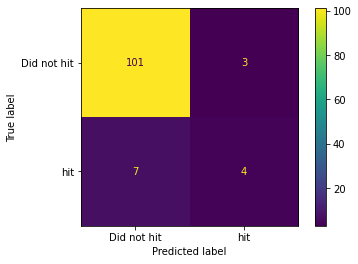

In [111]:
plot_confusion_matrix(clf_xgb2,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [112]:
X.columns

Index(['starter', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'hit_rate', 'Draft Pick', 'supporting_cast',
       'breakout_age', 'konami', 'games_played_rate'],
      dtype='object')

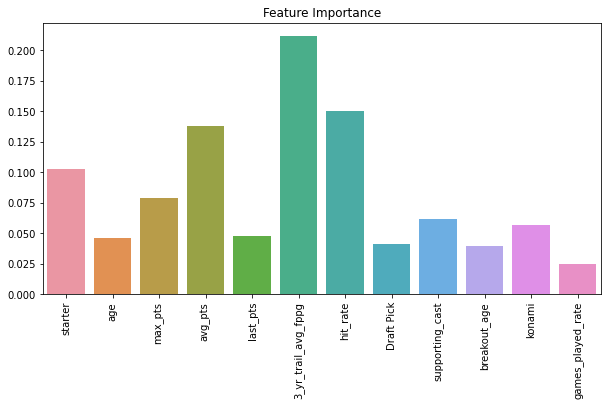

In [114]:
features = ['starter', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'hit_rate', 'Draft Pick', 'supporting_cast',
       'breakout_age', 'konami', 'games_played_rate']
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=clf_xgb2.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## Score 2022

In [115]:
brady_scores_2022 = pd.DataFrame(clf_xgb2.predict_proba(df_2022)).set_index(df_2022_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2022.to_csv('brady_scores_2022.csv')

In [116]:
brady_scores_2022

,0,1
id,,
Josh Allen,0.120672,0.879328
Deshaun Watson,0.138994,0.861006
Patrick Mahomes,0.164393,0.835607
Kyler Murray,0.199278,0.800722
Lamar Jackson,0.206116,0.793884
...,...,...
John Wolford,0.993901,0.006099
Feleipe Franks,0.993901,0.006099
Tyler Huntley,0.993901,0.006099


winner_df = j_scores_2022.reset_index().merge(adp_df[['Full Name','ADP']], left_on='id',right_on='Full Name')
winner_df.to_csv('winner_df.csv')

## Backtest

### 2021

In [117]:
X_2021 = df_2021.drop(columns=['y'])
X_2021

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,1,37.5,388.2592,307.094171,388.2592,20.288733,0.714286,1.24,1.662298,19.8,1.857143,0.919643
1,0,22.6,NaN,NaN,NaN,NaN,NaN,1.26,1.662298,19.8,NaN,NaN
2,0,25.9,NaN,NaN,NaN,NaN,NaN,NaN,1.662298,21.1,NaN,NaN
3,1,33.6,268.8000,218.014243,144.8997,15.490900,0.000000,2.03,1.754124,20.9,2.142857,0.857143
4,0,22.2,NaN,NaN,NaN,NaN,NaN,1.11,1.754124,20.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
80,1,32.9,351.3600,247.743333,351.3600,18.153333,0.166667,1.08,1.524542,22.1,2.333333,0.875000
81,1,24.4,423.0000,308.259833,341.7795,20.328433,0.666667,1.32,1.224198,18.7,6.333333,0.958333
82,0,23.3,2.9000,2.900000,2.9000,1.450000,0.000000,NaN,1.224198,21.6,0.000000,0.125000
83,0,26.2,NaN,NaN,NaN,NaN,NaN,5.34,0.989744,21.5,NaN,NaN


In [118]:
df_2021_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,1,1,37.5,388.2592,307.094171,388.2592,20.288733,0.714286,1.24,1.662298,19.8,1.857143,0.919643,Aaron Rodgers,2021
1,0,0,22.6,NaN,NaN,NaN,NaN,NaN,1.26,1.662298,19.8,NaN,NaN,Jordan Love,2021
2,0,0,25.9,NaN,NaN,NaN,NaN,NaN,NaN,1.662298,21.1,NaN,NaN,Kurt Benkert,2021
3,0,1,33.6,268.8000,218.014243,144.8997,15.490900,0.000000,2.03,1.754124,20.9,2.142857,0.857143,Andy Dalton,2021
4,0,0,22.2,NaN,NaN,NaN,NaN,NaN,1.11,1.754124,20.5,NaN,NaN,Justin Fields,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,1,32.9,351.3600,247.743333,351.3600,18.153333,0.166667,1.08,1.524542,22.1,2.333333,0.875000,Ryan Tannehill,2021
81,0,1,24.4,423.0000,308.259833,341.7795,20.328433,0.666667,1.32,1.224198,18.7,6.333333,0.958333,Lamar Jackson,2021
82,0,0,23.3,2.9000,2.900000,2.9000,1.450000,0.000000,NaN,1.224198,21.6,0.000000,0.125000,Tyler Huntley,2021
83,0,0,26.2,NaN,NaN,NaN,NaN,NaN,5.34,0.989744,21.5,NaN,NaN,Mike White,2021


In [119]:
id_2021 = qb_final_df[['Full Name','Fantasy Points Per Game (2021)']].dropna(subset=['Fantasy Points Per Game (2021)'])
id_2021

,Full Name,Fantasy Points Per Game (2021)
1,Aaron Rodgers,21.0813
5,Andy Dalton,11.6500
7,Baker Mayfield,13.8500
9,Ben Roethlisberger,14.2562
10,Blaine Gabbert,0.3300
...,...,...
167,Trey Lance,11.1533
168,Tua Tagovailoa,14.6862
170,Tyler Huntley,12.3771
171,Tyrod Taylor,14.4567


In [120]:
brady_scores_2021 = pd.DataFrame(clf_xgb2.predict_proba(X_2021)).set_index(df_2021_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2021

,0,1
id,,
Lamar Jackson,0.121480,0.878520
Josh Allen,0.134733,0.865267
Patrick Mahomes,0.139754,0.860246
Kyler Murray,0.151242,0.848758
Justin Herbert,0.226411,0.773589
...,...,...
Mike White,0.994326,0.005674
Trevor Siemian,0.994326,0.005674
Kevin Hogan,0.994326,0.005674


In [121]:
brady_scores_2021_check = brady_scores_2021.reset_index()
brady_scores_2021_check

,id,0,1
0,Lamar Jackson,0.121480,0.878520
1,Josh Allen,0.134733,0.865267
2,Patrick Mahomes,0.139754,0.860246
3,Kyler Murray,0.151242,0.848758
4,Justin Herbert,0.226411,0.773589
...,...,...,...
80,Mike White,0.994326,0.005674
81,Trevor Siemian,0.994326,0.005674
82,Kevin Hogan,0.994326,0.005674
83,Josh Rosen,0.994326,0.005674


In [122]:
df_2021['id'] = df_2021_id['id']
df_2021

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id
0,1,1,37.5,388.2592,307.094171,388.2592,20.288733,0.714286,1.24,1.662298,19.8,1.857143,0.919643,Aaron Rodgers
1,0,0,22.6,NaN,NaN,NaN,NaN,NaN,1.26,1.662298,19.8,NaN,NaN,Jordan Love
2,0,0,25.9,NaN,NaN,NaN,NaN,NaN,NaN,1.662298,21.1,NaN,NaN,Kurt Benkert
3,0,1,33.6,268.8000,218.014243,144.8997,15.490900,0.000000,2.03,1.754124,20.9,2.142857,0.857143,Andy Dalton
4,0,0,22.2,NaN,NaN,NaN,NaN,NaN,1.11,1.754124,20.5,NaN,NaN,Justin Fields
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,1,32.9,351.3600,247.743333,351.3600,18.153333,0.166667,1.08,1.524542,22.1,2.333333,0.875000,Ryan Tannehill
81,0,1,24.4,423.0000,308.259833,341.7795,20.328433,0.666667,1.32,1.224198,18.7,6.333333,0.958333,Lamar Jackson
82,0,0,23.3,2.9000,2.900000,2.9000,1.450000,0.000000,NaN,1.224198,21.6,0.000000,0.125000,Tyler Huntley
83,0,0,26.2,NaN,NaN,NaN,NaN,NaN,5.34,0.989744,21.5,NaN,NaN,Mike White


In [123]:
brady_scores_2021_check2 = brady_scores_2021_check.merge(df_2021, on='id',how='inner')
brady_scores_2021_check2.to_csv('brady_scores_2021_check.csv')

### 2020

In [124]:
X_2020 = df_2020.drop(columns=['y'])
X_2020

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,0,29.7,57.4,19.500000,17.8,3.433333,0.000000,5.24,1.037354,21.0,0.250000,0.203125
1,1,24.7,340.8,281.233333,330.0,22.666667,0.666667,1.12,1.037354,20.0,4.666667,0.791667
2,1,36.5,382.4,293.566667,276.8,18.666667,0.666667,1.24,1.473486,19.8,1.666667,0.906250
3,0,25.7,0.0,0.000000,0.0,0.000000,0.000000,NaN,1.473486,NaN,0.000000,0.187500
4,0,36.1,300.0,234.220000,NaN,17.150000,0.000000,1.01,0.865133,19.3,2.000000,0.887500
...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,28.4,-2.0,-2.000000,NaN,-2.000000,0.000000,NaN,1.447192,18.7,0.000000,0.062500
78,0,25.3,NaN,NaN,NaN,NaN,NaN,NaN,1.616799,18.5,NaN,NaN
79,1,27.6,208.0,99.000000,92.7,3.700000,0.000000,1.32,1.616799,18.8,0.800000,0.537500
80,1,37.5,300.8,191.133333,252.0,17.200000,0.166667,7.36,0.364208,20.8,1.666667,0.739583


In [125]:
df_2020_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,29.7,57.4,19.500000,17.8,3.433333,0.000000,5.24,1.037354,21.0,0.250000,0.203125,A.J. McCarron,2020
1,1,1,24.7,340.8,281.233333,330.0,22.666667,0.666667,1.12,1.037354,20.0,4.666667,0.791667,Deshaun Watson,2020
2,1,1,36.5,382.4,293.566667,276.8,18.666667,0.666667,1.24,1.473486,19.8,1.666667,0.906250,Aaron Rodgers,2020
3,0,0,25.7,0.0,0.000000,0.0,0.000000,0.000000,NaN,1.473486,NaN,0.000000,0.187500,Tim Boyle,2020
4,0,0,36.1,300.0,234.220000,NaN,17.150000,0.000000,1.01,0.865133,19.3,2.000000,0.887500,Alex Smith,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,0,28.4,-2.0,-2.000000,NaN,-2.000000,0.000000,NaN,1.447192,18.7,0.000000,0.062500,Tyler Bray,2020
78,0,0,25.3,NaN,NaN,NaN,NaN,NaN,NaN,1.616799,18.5,NaN,NaN,P.J. Walker,2020
79,0,1,27.6,208.0,99.000000,92.7,3.700000,0.000000,1.32,1.616799,18.8,0.800000,0.537500,Teddy Bridgewater,2020
80,0,1,37.5,300.8,191.133333,252.0,17.200000,0.166667,7.36,0.364208,20.8,1.666667,0.739583,Ryan Fitzpatrick,2020


In [126]:
brady_scores_2020 = pd.DataFrame(clf_xgb2.predict_proba(X_2020)).set_index(df_2020_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2020

,0,1
id,,
Deshaun Watson,0.118928,0.881072
Aaron Rodgers,0.175499,0.824501
Lamar Jackson,0.193739,0.806261
Tom Brady,0.231233,0.768767
Patrick Mahomes,0.324724,0.675276
...,...,...
Geno Smith,0.994326,0.005674
P.J. Walker,0.994326,0.005674
Chris Streveler,0.994326,0.005674


In [127]:
brady_scores_2020_check = brady_scores_2020.reset_index()
brady_scores_2020_check

,id,0,1
0,Deshaun Watson,0.118928,0.881072
1,Aaron Rodgers,0.175499,0.824501
2,Lamar Jackson,0.193739,0.806261
3,Tom Brady,0.231233,0.768767
4,Patrick Mahomes,0.324724,0.675276
...,...,...,...
77,Geno Smith,0.994326,0.005674
78,P.J. Walker,0.994326,0.005674
79,Chris Streveler,0.994326,0.005674
80,Easton Stick,0.994326,0.005674


In [128]:
df_2020['id'] = df_2020_id['id']
df_2020

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id
0,0,0,29.7,57.4,19.500000,17.8,3.433333,0.000000,5.24,1.037354,21.0,0.250000,0.203125,A.J. McCarron
1,1,1,24.7,340.8,281.233333,330.0,22.666667,0.666667,1.12,1.037354,20.0,4.666667,0.791667,Deshaun Watson
2,1,1,36.5,382.4,293.566667,276.8,18.666667,0.666667,1.24,1.473486,19.8,1.666667,0.906250,Aaron Rodgers
3,0,0,25.7,0.0,0.000000,0.0,0.000000,0.000000,NaN,1.473486,NaN,0.000000,0.187500,Tim Boyle
4,0,0,36.1,300.0,234.220000,NaN,17.150000,0.000000,1.01,0.865133,19.3,2.000000,0.887500,Alex Smith
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,0,28.4,-2.0,-2.000000,NaN,-2.000000,0.000000,NaN,1.447192,18.7,0.000000,0.062500,Tyler Bray
78,0,0,25.3,NaN,NaN,NaN,NaN,NaN,NaN,1.616799,18.5,NaN,NaN,P.J. Walker
79,0,1,27.6,208.0,99.000000,92.7,3.700000,0.000000,1.32,1.616799,18.8,0.800000,0.537500,Teddy Bridgewater
80,0,1,37.5,300.8,191.133333,252.0,17.200000,0.166667,7.36,0.364208,20.8,1.666667,0.739583,Ryan Fitzpatrick


In [129]:
brady_scores_2020_check2 = brady_scores_2020_check.merge(df_2020, on='id',how='inner')
brady_scores_2020_check2.to_csv('brady_scores_2020_check.csv')

[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=20.0, scale_pos_weight=1; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=30.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=20.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=30.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=20.0, scale_pos_weight=1; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=0, learning_rate=0.0